# Example 1: 2-D fault network extraction from a numerical model
This example describes how to extract a 2-D fault network from a numerical model simulating continental rifting. This example is based on the study of Naliboff et al. (2020).

## Setup

1. First, you will need sign in to your Google account. If you're not signed in, you can sign in [here](https://myaccount.google.com/?utm_source=sign_in_no_continue)
2. Next, head on to the [Colab Welcome Page](https://colab.research.google.com/notebooks/welcome.ipynb#recent=true).
3. There, select Github in the top tab and search for: https://github.com/thilowrona/fatbox_tutorials/blob/main/1-fault_extraction/1-fault_extraction.ipynb
4. Clicking opens this notebook. This is a Jupyter notebook; an awesome combination of code and documentation allowing us work on, describe and share our projects.
5. When you run the first cell, you will face a pop-up saying ‘Warning: This notebook was not authored by Google’; you should click on ‘Run Anyway’ to get rid of the warning.
6. Next we want to save our notebook. If you click on ‘File’ and then ‘Save’, you will see a pop-up saying ´CANNOT SAVE CHANGES´. Now, click on ‘SAVE A COPY IN DRIVE’. This opens up a new tab with the same file, but this time located in your Drive. If you want to continue working after saving, use the file in the new tab. Your notebook will be saved in a folder called Colab Notebooks in your Google Drive by default.

## Load packages
To run the toolbox, we will need a couple of packages including the toolbox itself. So let's install it:

In [147]:
# !pip3 install git+https://github.com/thilowrona/fatbox.git

download the tutorials:

In [148]:
# !git clone https://github.com/thilowrona/fatbox_tutorials

Now we can load the python packages that we need:

In [320]:
import numpy as np 
import networkx as nx
import pickle
import cv2
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial import distance_matrix

from sys import stdout

from fatbox.preprocessing import simple_threshold_binary, skeleton_guo_hall, array_to_points
from fatbox.edits import label_components, simplify
from fatbox.plots import plot_components

import pyvista as pv
import cmcrameri.cm as cmc
import geovista as gv
from geovista.common import to_cartesian
# from geovista.common import to_xyz

## Fault extraction

First, we load our data - a strain rate map extracted just below the surface of the model:

In [321]:
# file_path = '/Volumes/Jerry/global_models_3d/R01e_Rodinia_2GPa_Mantle_C20MPa_f003_LR/solution/solution_surface-00110.0000.vtu'
file_path = '/Volumes/Jerry/global_models_3d/V06a_R01f_Rodinia_2GPa_llsvps_ps_1x50My_init_2Myint/solution/solution_surface-00022.0000.vtu'

data = pv.read(file_path)
print(data)

# Display the names of the arrays in point data
print("Point Data Arrays:")
for name in data.point_data.keys():
    print(f" - {name}")

# # Display the names of the arrays in cell data
# print("Cell Data Arrays:")
# for name in data.cell_data.keys():
#     print(f" - {name}")

# Displaying the actual arrays (optional, for debugging purposes)
print("\nActual Point Data Arrays:")
for name, array in data.point_data.items():
    print(f"\n{name}:")
    print(array)

# print("\nActual Cell Data Arrays:")
# for name, array in data.cell_data.items():
#     print(f"\n{name}:")
#     print(array)


UnstructuredGrid (0x4a886a7a0)
  N Cells:    835584
  N Points:   1880064
  X Bounds:   -6.371e+06, 6.371e+06
  Y Bounds:   -6.371e+06, 6.371e+06
  Z Bounds:   -6.371e+06, 6.371e+06
  N Arrays:   11
Point Data Arrays:
 - surface_velocity
 - surface_strain_rate_tensor
 - surface_stress
 - surface_p
 - surface_T
 - surface_continent
 - surface_asthenosphere
 - surface_llsvps
 - surface_plastic_strain

Actual Point Data Arrays:

surface_velocity:
[[ 6.9132322e-03  0.0000000e+00  5.0478582e-03]
 [ 7.0207254e-03 -1.9685831e-05  5.1557673e-03]
 [ 7.1282191e-03 -3.9371662e-05  5.2636759e-03]
 ...
 [-3.7437461e-03 -7.0203687e-03 -1.7438198e-02]
 [-3.7710969e-03 -6.9834050e-03 -1.7381093e-02]
 [-3.7984753e-03 -6.9464510e-03 -1.7324079e-02]]

surface_strain_rate_tensor:
[[ 7.44244904e-17  1.77895109e-15  7.48228043e-18 ...  7.48228043e-18
   3.48861901e-16 -3.87446927e-19]
 [ 7.44244904e-17  1.77895109e-15  7.48228043e-18 ...  7.48228043e-18
   3.48861901e-16 -3.87446927e-19]
 [ 7.44244904e-17  

In [322]:
# Access the strain rate tensor array
strain_rate_tensor = data.point_data['surface_strain_rate_tensor']

# Calculate the magnitude (Frobenius norm) of the strain rate tensor
strain_rate_magnitude = np.linalg.norm(strain_rate_tensor, axis=1)

# Calculate the log10 of the strain rate magnitude
strain_rate_magnitude_log10 = np.log10(strain_rate_magnitude)

# Add the log10 magnitude array to the dataset for visualization or further analysis
data.point_data['strain_rate_magnitude'] = strain_rate_magnitude_log10

# Calculate radius and topography
radius = np.sqrt(data.points[:, 0]**2 + data.points[:, 1]**2 + data.points[:, 2]**2)
topography = radius - 6371000  # Assuming Earth's radius in meters

# Convert coordinates to degrees
longitude = np.arctan2(data.points[:, 1], data.points[:, 0]) * 180 / np.pi
latitude = np.arcsin(data.points[:, 2] / radius) * 180 / np.pi

print(longitude,latitude)
# Add topography, longitude, and latitude as scalar arrays to the mesh
data.point_data['Topography'] = topography
data.point_data['Longitude'] = longitude
data.point_data['Latitude'] = latitude

# # Print the first few values for verification
# print("Magnitudes of strain rate tensor:")
# print(strain_rate_magnitude[:10])

# print("First few values of longitude:")
# print(longitude[:10])

# Optionally, visualize the result
plotter = pv.Plotter()
plotter.add_mesh(data, scalars='strain_rate_magnitude', cmap='viridis', clim=[-16, -14])
# plotter.add_scalar_bar(title='Log10 Strain Rate Magnitude')
plotter.show()


[-90.       -90.60477  -91.20967  ...  19.766382  19.935001  20.103909] [  0.          0.6047375   1.2094077 ... -18.684807  -18.82701
 -18.969065 ]


Widget(value='<iframe src="http://localhost:65455/index.html?ui=P_0x2df504970_41&reconnect=auto" class="pyvist…

In [323]:
max(latitude)

np.float32(89.99999)

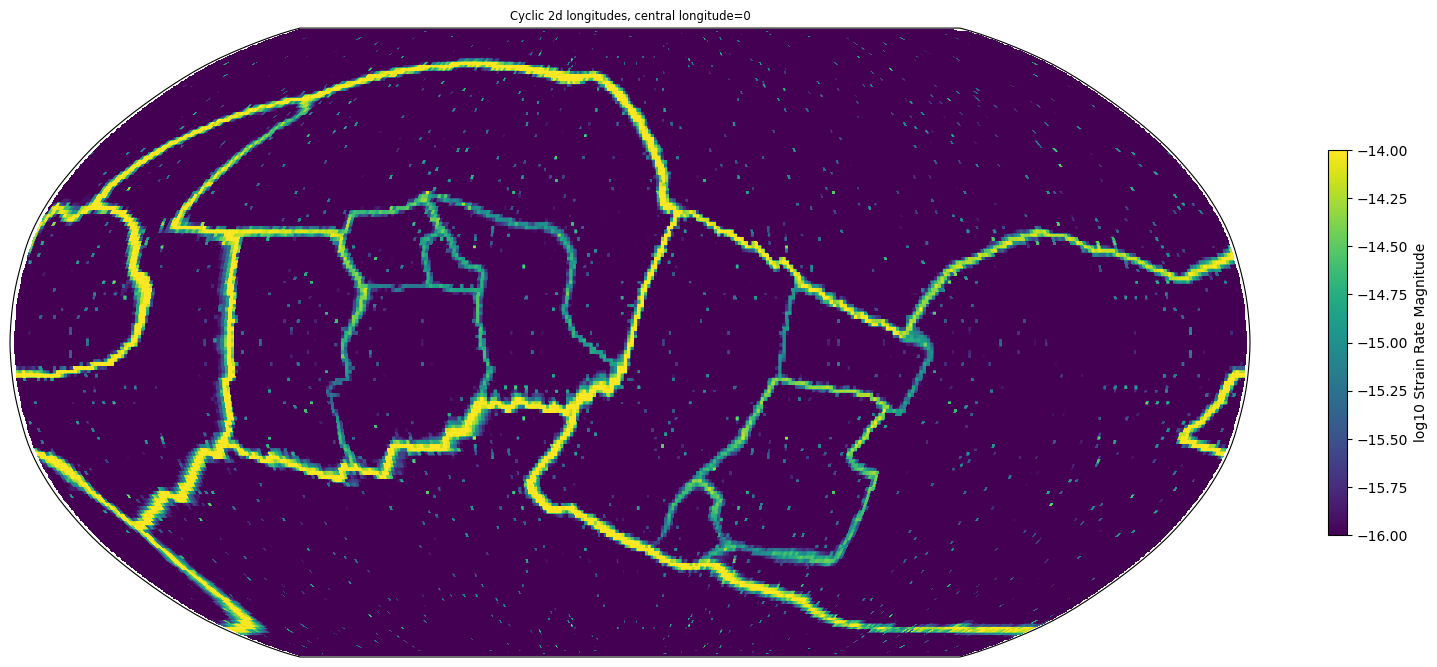

In [324]:
import matplotlib.pyplot as plt
import cartopy.util as cutil
# from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
import numpy as np
from scipy.interpolate import griddata

# Define grid of longitude and latitude for interpolation
lon_grid, lat_grid = np.meshgrid(np.linspace(-180, 180, 360), np.linspace(-90, 90, 180))

# Interpolate strain_rate_magnitude_log10 onto lon_grid, lat_grid
strain_rate_magnitude_interp = griddata((longitude, latitude), strain_rate_magnitude_log10,
                                        (lon_grid, lat_grid), method='linear')
# strain_rate_magnitude_smoothed = gaussian_filter(strain_rate_magnitude_interp, sigma=1.0)

cdata, clon2d, clat2d = cutil.add_cyclic(strain_rate_magnitude_interp, lon_grid, lat_grid)
fig = plt.figure(figsize=(20, 10))
ax4 = fig.add_subplot(111,
                    projection=ccrs.Robinson(central_longitude=0))
ax4.set_title("Cyclic 2d longitudes, central longitude=0",
            fontsize='small')
ax4.set_global()

# img=ax4.contourf(clon2d, clat2d, cdata,
#             transform=ccrs.PlateCarree(), cmap='RdBu')

img = ax4.imshow(cdata, transform=ccrs.PlateCarree(), cmap='viridis', vmin=-16, vmax=-14, origin='lower')

# Add colorbar
cbar = fig.colorbar(img, ax=ax4, orientation='vertical', shrink=0.5)
cbar.set_label('log10 Strain Rate Magnitude')

# Set labels for x and y axes
ax4.set_xlabel('Longitude [°]')
ax4.set_ylabel('Latitude [°]')

# Show the plot
plt.show()

In [325]:

# # data = pd.read_csv('/Volumes/Jerry/global_models_3d/R01e_Rodinia_2GPa_Mantle_C20MPa_f003_LR/solution_surface.pvd')
# data_array = data.to_numpy()  # Convert DataFrame to numpy array

# print(data)
# # Access the 'strain_rate' column and slice it
# strain_rate = data['strain_rate'].values

# # print(strain_rate)
# # strain_rate_sliced = strain_rate[:400, 250:450]

Now we can plot it to look the faults in the model

In [326]:
# fig, ax = plt.subplots(figsize=(10,10))
# im = ax.imshow(strain_rate, vmin=0)
# plt.axis('off')
# divider = make_axes_locatable(ax)
# cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
# fig.add_axes(cax)
# fig.colorbar(im, cax=cax, orientation="horizontal")
# plt.show()

Next we want to separate the faults from the background using a threshold:

In [327]:
from fatbox.preprocessing import simple_threshold_binary, skeleton_guo_hall, array_to_points
from fatbox.edits import label_components, simplify
from fatbox.plots import plot_components
# data_array = cdata.to_numpy()
print(cdata)
threshold = simple_threshold_binary(10**(cdata), 5e-16)

# fig, ax = plt.subplots(figsize=(10,10))
# im = ax.imshow(threshold, vmin=0, vmax=1)
# plt.axis('off')
# divider = make_axes_locatable(ax)
# cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
# fig.add_axes(cax)
# fig.colorbar(im, cax=cax, orientation="horizontal")
# plt.show()

[[         nan          nan          nan ...          nan          nan
           nan]
 [         nan -17.61273379 -17.6120244  ... -17.55410826 -17.57562459
           nan]
 [         nan -17.64549014 -17.62997478 ... -16.57536036 -16.14006447
           nan]
 ...
 [         nan -18.03070398 -18.00708395 ... -16.39896969 -18.00094721
           nan]
 [         nan -18.05720333 -18.12607187 ...          nan          nan
           nan]
 [         nan          nan          nan ...          nan          nan
           nan]]


Now we can reduce the areas above the threshold to lines using a skeletonize algorithm:

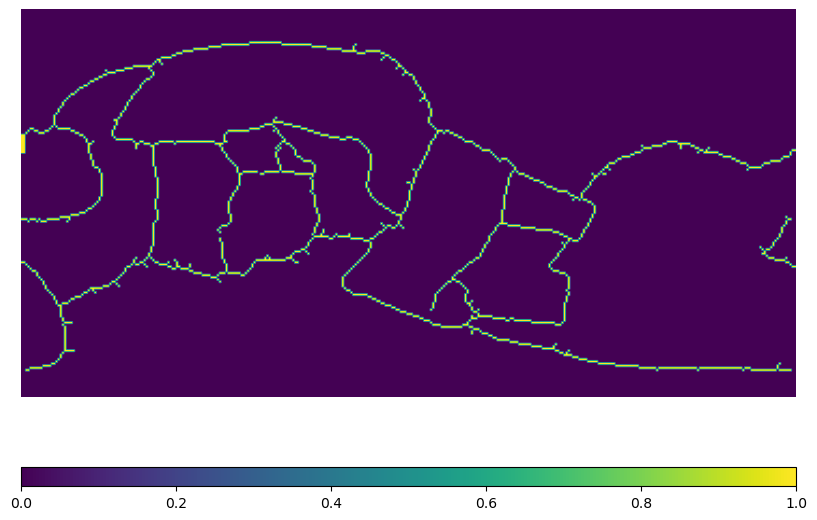

In [328]:
# skeleton = skeleton_guo_hall(threshold)

# fig, ax = plt.subplots(figsize=(10,10))
# im = ax.imshow(skeleton, vmin=0, vmax=1)
# plt.axis('off')
# divider = make_axes_locatable(ax)
# cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
# fig.add_axes(cax)
# fig.colorbar(im, cax=cax, orientation="horizontal")
# plt.show()

# import numpy as np
# from skimage import measure

# # Label connected components
# labels = measure.label(skeleton, connectivity=2)

# # Get the properties of labeled regions
# props = measure.regionprops(labels)

# # Filter out small objects based on area or other properties
# min_area = 4  # Set this according to your needs
# skeleton_cleaned = np.zeros_like(skeleton, dtype=bool)
# for prop in props:
#     if prop.area >= min_area:
#         skeleton_cleaned[labels == prop.label] = 1

# # Plot the cleaned skeleton
# fig, ax = plt.subplots(figsize=(10,10))
# im = ax.imshow(skeleton_cleaned, vmin=0, vmax=1)
# plt.axis('off')
# divider = make_axes_locatable(ax)
# cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
# fig.add_axes(cax)
# fig.colorbar(im, cax=cax, orientation="horizontal")
# plt.show()


import numpy as np
from skimage import measure
import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import make_axes_locatable

# Assuming `skeleton` is your input image after skeletonization

# Label connected components
labels = measure.label(skeleton, connectivity=2)

# Get the properties of labeled regions
props = measure.regionprops(labels)

# Filter out small objects based on area or other properties
min_area = 4  # Set this according to your needs
skeleton_cleaned = np.zeros_like(skeleton, dtype=bool)
for prop in props:
    if prop.area >= min_area:
        skeleton_cleaned[labels == prop.label] = 1

# Flip the skeleton vertically (flip latitude)
skeleton_cleaned_flipped = np.flipud(skeleton_cleaned)

# Plot the cleaned and flipped skeleton
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(skeleton_cleaned_flipped, vmin=0, vmax=1)
plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
fig.add_axes(cax)
fig.colorbar(im, cax=cax, orientation="horizontal")
plt.show()


# another possibility to filter is
# skeleton = skeleton_guo_hall(threshold)
# skeleton_cleaned = morphology.remove_small_objects(skeleton.astype(bool), min_size=2)
# fig, ax = plt.subplots(figsize=(10,10))
# im = ax.imshow(skeleton_cleaned, vmin=0, vmax=1)
# plt.axis('off')
# divider = make_axes_locatable(ax)
# cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
# fig.add_axes(cax)
# fig.colorbar(im, cax=cax, orientation="horizontal")
# plt.show()


Now we can convert these lines to points:

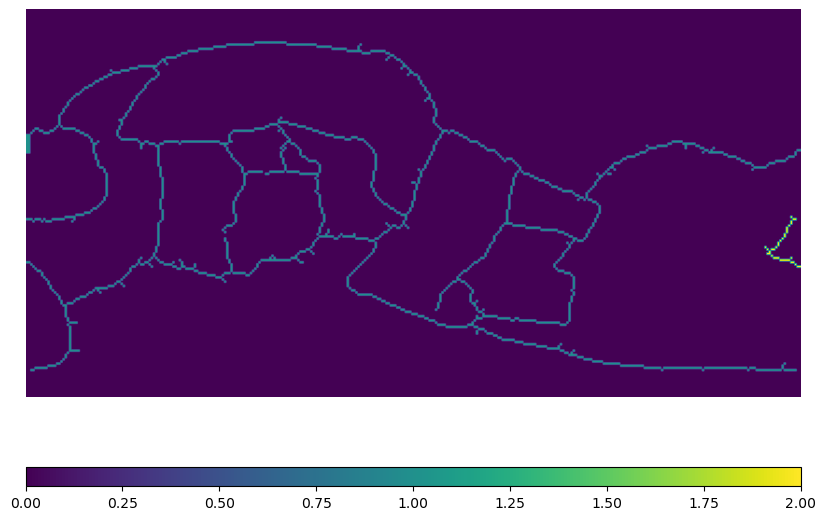

In [329]:
# ret, markers = cv2.connectedComponents(skeleton_cleaned_flipped,connectivity= 8)

# fig, ax = plt.subplots(figsize=(10,10))
# im = ax.imshow(markers, vmin=0)
# plt.axis('off')
# divider = make_axes_locatable(ax)
# cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
# fig.add_axes(cax)
# fig.colorbar(im, cax=cax, orientation="horizontal")
# plt.show()

# Convert the binary image to uint8 for OpenCV
skeleton_cleaned_flipped_uint8 = (skeleton_cleaned_flipped * 255).astype(np.uint8)

# Use OpenCV to label connected components
ret, markers = cv2.connectedComponents(skeleton_cleaned_flipped_uint8, connectivity=8)

# Plot the labeled components
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(markers, vmin=0)
plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
fig.add_axes(cax)
fig.colorbar(im, cax=cax, orientation="horizontal")
plt.show()

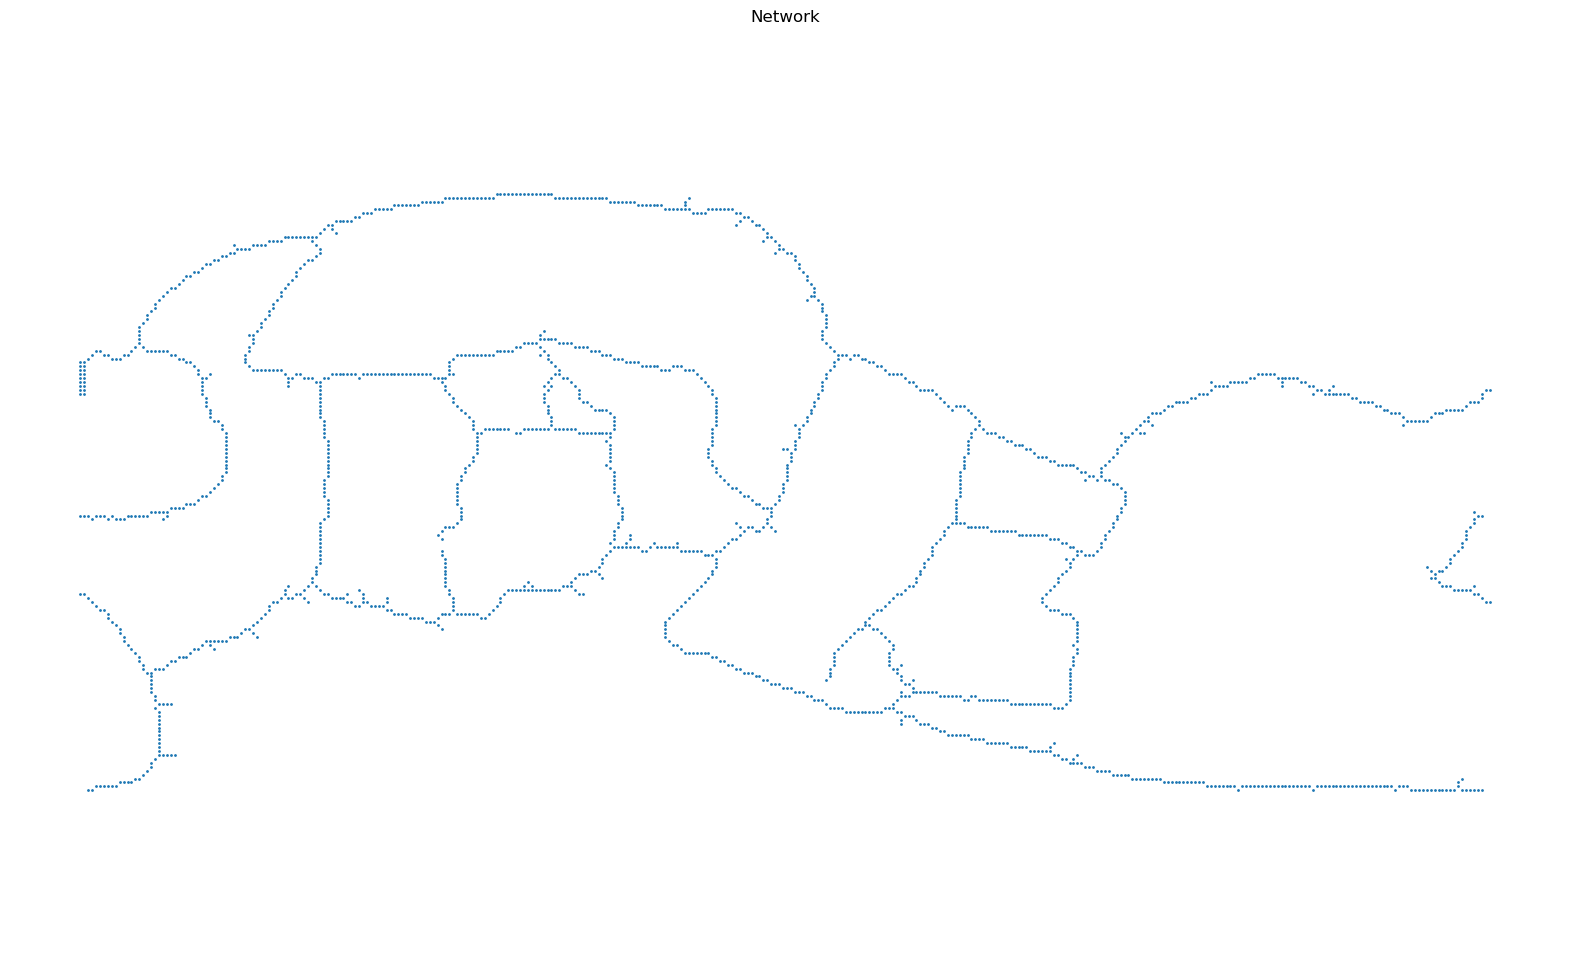

In [330]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
node = 0

# Get the height of the image to invert the y-coordinate
image_height = skeleton_cleaned_flipped.shape[0]

for comp in range(1, ret):
    points = np.transpose(np.vstack((np.where(markers == comp))))

    for point in points:
        G.add_node(node)
        
        # Invert the y-coordinate to match graph plotting
        y_coordinate = image_height - point[0]
        
        G.nodes[node]['pos'] = (point[1], y_coordinate)  # (x, y) = (col, row)
        G.nodes[node]['component'] = comp
        node += 1

# Plot the graph
fig, ax = plt.subplots(figsize=(20, 12))
ax.set_title('Network')

# Draw the NetworkX graph on the plot
nx.draw(G, 
        pos=nx.get_node_attributes(G, 'pos'), 
        node_size=1,
        ax=ax)
ax.axis('equal')
plt.show()


In [331]:
import numpy as np
import networkx as nx
import pyvista as pv

def latlon_to_cartesian(lat, lon):
    """
    Convert latitude and longitude to Cartesian coordinates.
    """
    lat, lon = np.radians(lat), np.radians(lon)
    x = 6371000 * np.cos(lat) * np.cos(lon)
    y = 6371000 * np.cos(lat) * np.sin(lon)
    z = 6371000 * np.sin(lat)
    return x, y, z

# Create the graph
G = nx.Graph()
node = 0

# Get the height of the image to invert the y-coordinate
image_height = skeleton_cleaned_flipped.shape[0]

for comp in range(1, ret):
    points = np.transpose(np.vstack((np.where(markers == comp))))

    for point in points:
        G.add_node(node)
        
        # Invert the y-coordinate to match graph plotting
        y_coordinate = image_height - point[0]
        
        G.nodes[node]['pos'] = (point[1], y_coordinate)  # (x, y) = (col, row)
        G.nodes[node]['component'] = comp
        node += 1

# Convert positions to Cartesian coordinates
cartesian_positions = {}
points = []

for node in G.nodes:
    lon, lat = G.nodes[node]['pos']
    # Transform the (col, row) coordinates to lat, lon assuming the image covers the entire globe
    lon = (lon / skeleton_cleaned_flipped.shape[1]) * 360 - 180
    lat = (lat / skeleton_cleaned_flipped.shape[0]) * 180 - 90
    
    x, y, z = latlon_to_cartesian(lat, lon)
    points.append([x, y, z])
    cartesian_positions[node] = (x, y, z)

# Create a PyVista plotter
plotter = pv.Plotter()

# Add a sphere to represent the Earth
sphere = pv.Sphere(radius=6371000, theta_resolution=360, phi_resolution=180)
plotter.add_mesh(sphere, color='white', opacity=0.6, style='wireframe')

# Add nodes to the plotter
points = np.array(points)
point_cloud = pv.PolyData(points)
plotter.add_mesh(point_cloud, color='red', point_size=10, render_points_as_spheres=True)

# Add edges to the plotter
for edge in G.edges:
    pos1 = cartesian_positions[edge[0]]
    pos2 = cartesian_positions[edge[1]]
    line = pv.Line(pos1, pos2)
    plotter.add_mesh(line, color='blue', line_width=0.5)

# Show the plot
plotter.show()


Widget(value='<iframe src="http://localhost:65455/index.html?ui=P_0x42966ea70_42&reconnect=auto" class="pyvist…

These points become the nodes of our graph G:

In [332]:
# G = nx.Graph()

# node = 0
# for comp in range(1,ret):

#     points = np.transpose(np.vstack((np.where(markers==comp))))    
    
#     for point in points:
#         G.add_node(node)
#         G.nodes[node]['pos'] = (point[1], point[0])
#         G.nodes[node]['component'] = comp
#         node += 1    

Remember a graph is an object consisting only of nodes and edges. Our graph for example looks like this:

In [333]:
# import matplotlib.pyplot as plt
# import networkx as nx

# fig, ax = plt.subplots(figsize=(20, 12))

# # Set title for the plot
# ax.set_title('Network')

# # Draw the NetworkX graph on the single plot
# nx.draw(G, 
#         pos=nx.get_node_attributes(G, 'pos'), 
#         node_size=1,
#         ax=ax)
# ax.axis('equal')

# plt.show()


You can see that the graph only consists of closely spaced points, which are not yet connected. So let's change that!


We calculate the distance between all nodes of a component in a distance matrix and connect the ones close to each other (<1.5 pixels away):

In [334]:
# for comp in range(1,ret): 
    
#     points = [G.nodes[node]['pos'] for node in G if G.nodes[node]['component']==comp]
#     nodes  = [node for node in G if G.nodes[node]['component']==comp]

#     dm = distance_matrix(points, points)  
    
    
#     for n in range(len(points)):
#         # print(n)
#         for m in range(len(points)):
#             if dm[n,m]<2 and n != m:
#                 G.add_edge(nodes[n],nodes[m])


print("Number of connected components (including background):", ret)


from scipy.spatial import distance_matrix
import numpy as np

for comp in range(1, ret):
    points = [G.nodes[node]['pos'] for node in G if G.nodes[node]['component'] == comp]
    nodes = [node for node in G if G.nodes[node]['component'] == comp]

    # Check if there are enough points to form a matrix
    if len(points) > 1:
        dm = distance_matrix(points, points)

        for n in range(len(points)):
            for m in range(len(points)):
                if dm[n, m] < 2 and n != m:
                    G.add_edge(nodes[n], nodes[m])
    else:
        print(f"Component {comp} does not have enough points for distance matrix calculation.")


Number of connected components (including background): 3


In [335]:
# fig, ax = plt.subplots(1, figsize=(20, 12))

# ax.set_title('Graph')
# nx.draw(G, 
#         pos=nx.get_node_attributes(G, 'pos'), 
#         node_size=1,
#         ax=ax)
# ax.axis('equal')

# plt.show()


for comp in range(1, ret):
    points = [G.nodes[node]['pos'] for node in G if G.nodes[node]['component'] == comp]
    nodes = [node for node in G if G.nodes[node]['component'] == comp]

    # Check if there are enough points to form a matrix
    if len(points) > 1:
        dm = distance_matrix(points, points)

        for n in range(len(points)):
            for m in range(len(points)):
                if dm[n, m] < 2 and n != m:
                    G.add_edge(nodes[n], nodes[m])
    else:
        print(f"Component {comp} does not have enough points for distance matrix calculation.")

# Convert positions to Cartesian coordinates
cartesian_positions = {}
points = []

for node in G.nodes:
    lon, lat = G.nodes[node]['pos']
    # Transform the (col, row) coordinates to lat, lon assuming the image covers the entire globe
    lon = (lon / skeleton_cleaned_flipped.shape[1]) * 360 - 180
    lat = (lat / skeleton_cleaned_flipped.shape[0]) * 180 - 90
    
    x, y, z = latlon_to_cartesian(lat, lon)
    points.append([x, y, z])
    cartesian_positions[node] = (x, y, z)

# Create a PyVista plotter
plotter = pv.Plotter()

# Add a sphere to represent the Earth
sphere = pv.Sphere(radius=6371000, theta_resolution=360, phi_resolution=180)
plotter.add_mesh(sphere, color='white', opacity=0.6, style='wireframe')

# Add nodes to the plotter
points = np.array(points)
point_cloud = pv.PolyData(points)
plotter.add_mesh(point_cloud, color='red', point_size=10, render_points_as_spheres=True)

# Add edges to the plotter
for edge in G.edges:
    pos1 = cartesian_positions[edge[0]]
    pos2 = cartesian_positions[edge[1]]
    line = pv.Line(pos1, pos2)
    plotter.add_mesh(line, color='blue', line_width=0.5)

# Show the plot
plotter.show()


Widget(value='<iframe src="http://localhost:65455/index.html?ui=P_0x2df4c2320_43&reconnect=auto" class="pyvist…

In [336]:
# # Label components
# G = label_components(G)

# # Convert positions to Cartesian coordinates
# cartesian_positions = {}
# points = []

# for node in G.nodes:
#     lon, lat = G.nodes[node]['pos']
#     # Transform the (col, row) coordinates to lat, lon assuming the image covers the entire globe
#     lon = (lon / skeleton_cleaned_flipped.shape[1]) * 360 - 180
#     lat = (lat / skeleton_cleaned_flipped.shape[0]) * 180 - 90
    
#     x, y, z = latlon_to_cartesian(lat, lon)
#     points.append([x, y, z])
#     cartesian_positions[node] = (x, y, z)

# # Create a PyVista plotter
# plotter = pv.Plotter()

# # Add a sphere to represent the Earth
# sphere = pv.Sphere(radius=6371000, theta_resolution=360, phi_resolution=180)
# plotter.add_mesh(sphere, color='white', opacity=0.6, style='wireframe')

# # Add nodes to the plotter with colors based on their component
# points = np.array(points)
# point_cloud = pv.PolyData(points)
# point_cloud['component'] = [G.nodes[node]['component'] for node in G.nodes]
# plotter.add_mesh(point_cloud, scalars='component', render_points_as_spheres=True, point_size=10)

# # Add edges to the plotter
# for edge in G.edges:
#     pos1 = cartesian_positions[edge[0]]
#     pos2 = cartesian_positions[edge[1]]
#     line = pv.Line(pos1, pos2)
#     plotter.add_mesh(line, color='blue', line_width=0.5)

# # Show the plot
# plotter.show()

Now we can see that neighboring nodes are connected by edges (black lines). This allows us to label the nodes connected to one another as components:

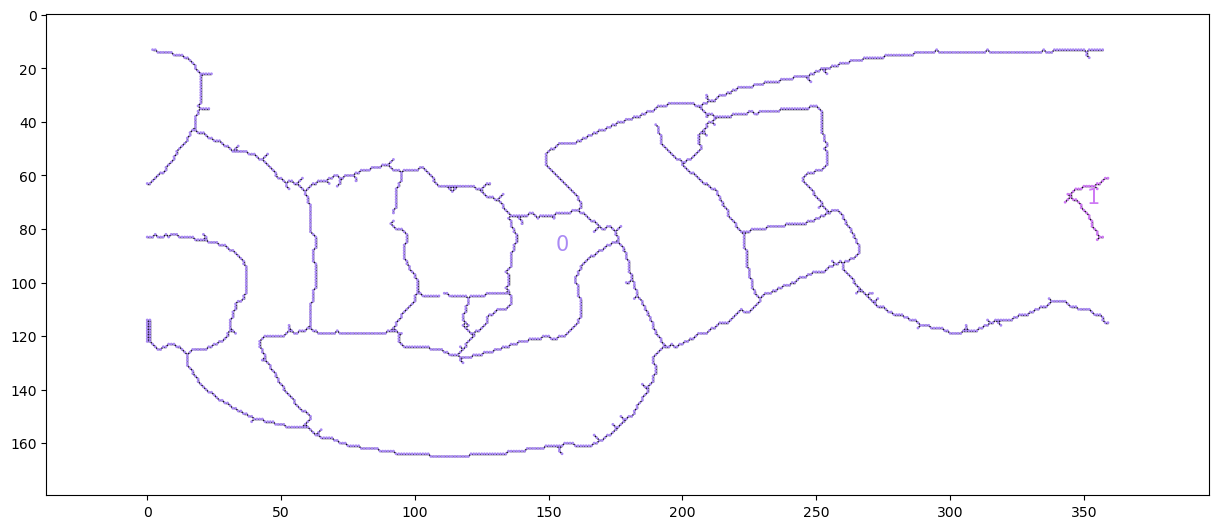

Graph with 1740 nodes and 1824 edges


In [305]:
# G = label_components(G)

# fig, ax = plt.subplots(1, 1, figsize=(15,15))
# ax.imshow(np.zeros_like(cdata), 'gray_r', vmin=0)
# plot_components(G, node_size=1, ax=ax)
# # ax.set_xlim(0,200)
# # ax.set_ylim(400,0)
# plt.show()
# print(G)

Connecting 381 to 517 across the dateline with distance 4.47213595499958
Connecting 381 to 518 across the dateline with distance 4.123105625617661
Connecting 382 to 518 across the dateline with distance 4.47213595499958
Connecting 428 to 517 across the dateline with distance 3.605551275463989
Connecting 428 to 518 across the dateline with distance 3.1622776601683795
Connecting 429 to 517 across the dateline with distance 4.242640687119285
Connecting 429 to 518 across the dateline with distance 3.605551275463989
Connecting 458 to 517 across the dateline with distance 2.8284271247461903
Connecting 458 to 518 across the dateline with distance 2.23606797749979
Connecting 458 to 540 across the dateline with distance 4.242640687119285
Connecting 459 to 517 across the dateline with distance 3.605551275463989
Connecting 459 to 518 across the dateline with distance 2.8284271247461903
Connecting 480 to 517 across the dateline with distance 2.23606797749979
Connecting 480 to 518 across the dateli

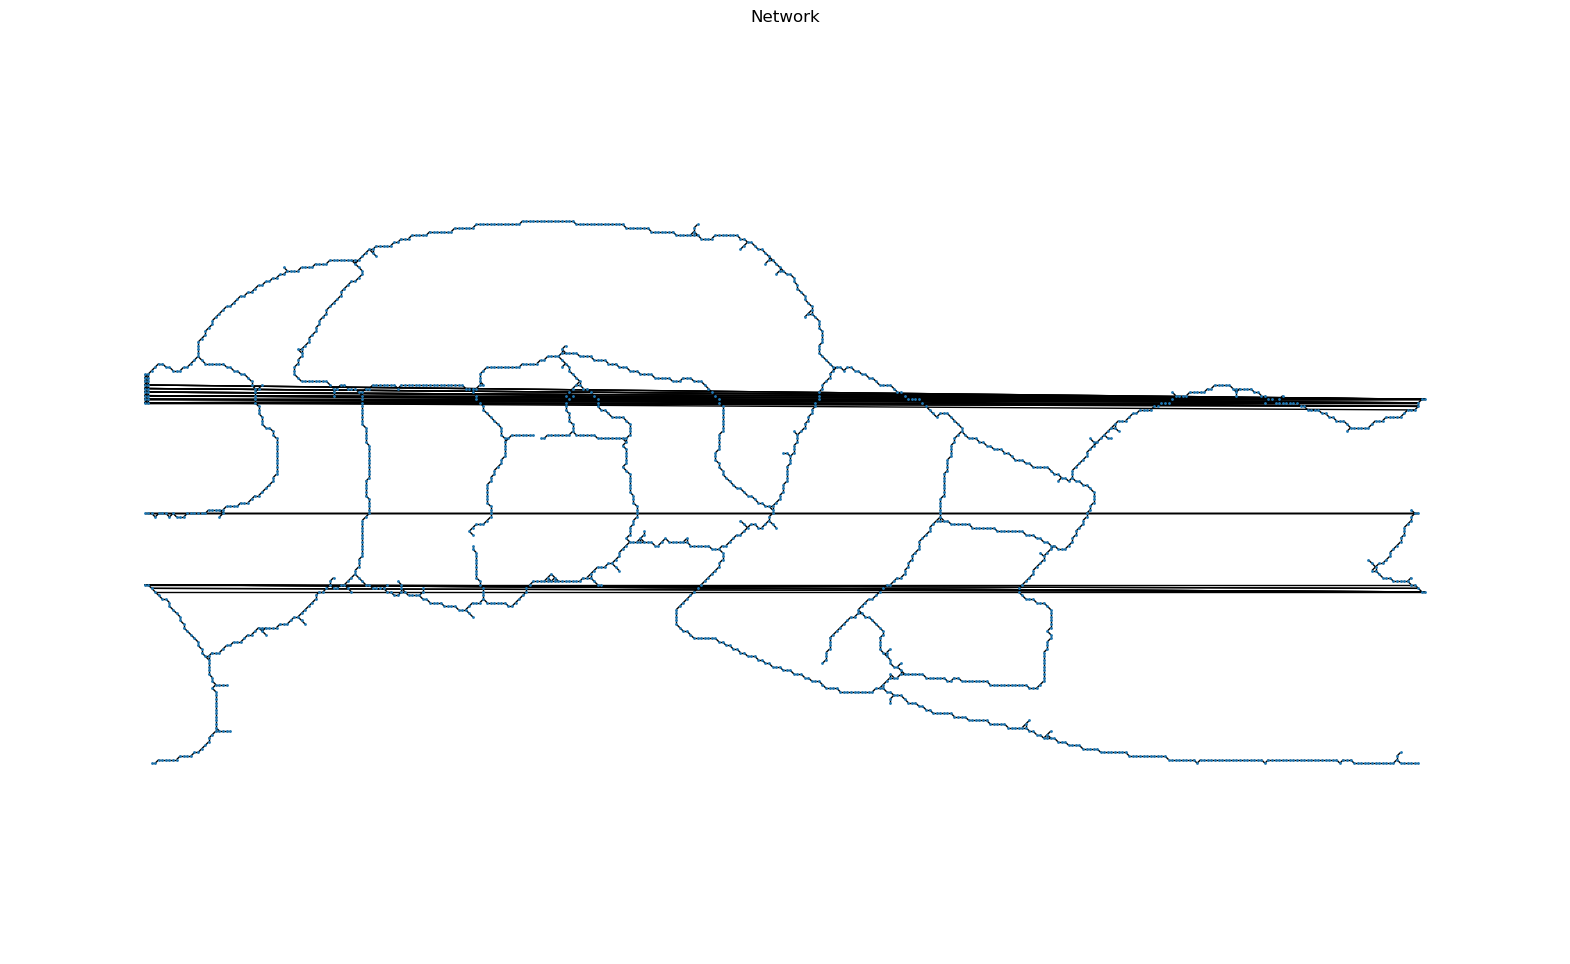

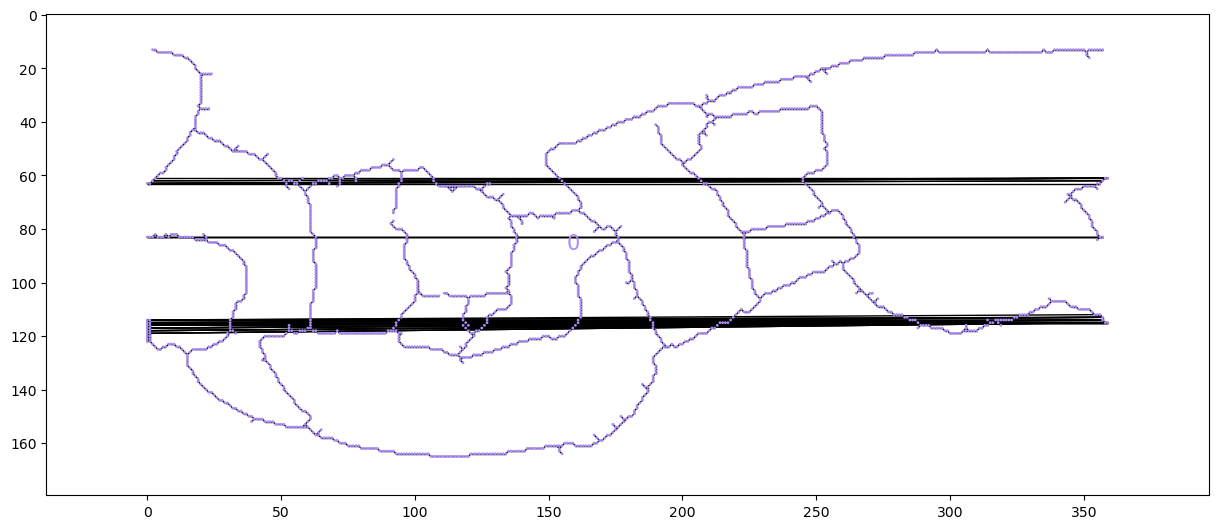

Graph with 1740 nodes and 1873 edges


In [261]:
# # Lets connect the nodes in longitude 
# import numpy as np
# import networkx as nx
# import matplotlib.pyplot as plt
# from scipy.spatial import distance_matrix

# def connect_across_dateline(G, threshold=2):
#     # Extract positions and components
#     pos = nx.get_node_attributes(G, 'pos')
#     components = nx.get_node_attributes(G, 'component')
    
#     # Convert positions to arrays for easier manipulation
#     positions = np.array([pos[node] for node in G.nodes])
#     nodes = np.array(list(G.nodes))
    
#     # Identify nodes near the -180 and 180 degree longitudes
#     left_edge_nodes = nodes[positions[:, 0] < 10]  # Near -180 degrees
#     right_edge_nodes = nodes[positions[:, 0] > 350]  # Near 180 degrees
    
#     # Calculate distances across the dateline
#     left_positions = positions[positions[:, 0] < 10]
#     right_positions = positions[positions[:, 0] > 350]
    
#     if len(left_positions) > 0 and len(right_positions) > 0:
#         left_positions[:, 0] += 360  # Shift to the right side for distance calculation
#         dm = distance_matrix(left_positions, right_positions)
        
#         for i, left_node in enumerate(left_edge_nodes):
#             for j, right_node in enumerate(right_edge_nodes):
#                 if dm[i, j] < threshold:
#                     G.add_edge(left_node, right_node)
#                     print(f"Connecting {left_node} to {right_node} across the dateline with distance {dm[i, j]}")

# # Connect components across the dateline
# connect_across_dateline(G, threshold=5)

# # Plot the graph
# fig, ax = plt.subplots(figsize=(20, 12))
# ax.set_title('Network')
# nx.draw(G, pos=nx.get_node_attributes(G, 'pos'), node_size=1, ax=ax)
# ax.axis('equal')
# plt.show()

# # Label components in the graph
# G = label_components(G)

# # Plot labeled components
# fig, ax = plt.subplots(1, 1, figsize=(15, 15))
# ax.imshow(np.zeros_like(skeleton_cleaned_flipped), 'gray_r', vmin=0)
# plot_components(G, node_size=1, ax=ax)
# plt.show()

# print(f"Graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")


In [337]:
import numpy as np
import networkx as nx
import pyvista as pv
from scipy.spatial import distance_matrix

def latlon_to_cartesian(lat, lon):
    """
    Convert latitude and longitude to Cartesian coordinates.
    """
    lat, lon = np.radians(lat), np.radians(lon)
    x = 6371000 * np.cos(lat) * np.cos(lon)
    y = 6371000 * np.cos(lat) * np.sin(lon)
    z = 6371000 * np.sin(lat)
    return x, y, z

# Function to connect components across the dateline
def connect_across_dateline(G, threshold=2):
    pos = nx.get_node_attributes(G, 'pos')
    components = nx.get_node_attributes(G, 'component')

    positions = np.array([pos[node] for node in G.nodes])
    nodes = np.array(list(G.nodes))

    left_edge_nodes = nodes[positions[:, 0] < 10]  # Near -180 degrees
    right_edge_nodes = nodes[positions[:, 0] > 350]  # Near 180 degrees

    left_positions = positions[positions[:, 0] < 10]
    right_positions = positions[positions[:, 0] > 350]

    if len(left_positions) > 0 and len(right_positions) > 0:
        left_positions[:, 0] += 360  # Shift to the right side for distance calculation
        dm = distance_matrix(left_positions, right_positions)

        for i, left_node in enumerate(left_edge_nodes):
            for j, right_node in enumerate(right_edge_nodes):
                if dm[i, j] < threshold:
                    G.add_edge(left_node, right_node)
                    print(f"Connecting {left_node} to {right_node} across the dateline with distance {dm[i, j]}")


G = label_components(G)

# Convert positions to Cartesian coordinates
cartesian_positions = {}
points = []

for node in G.nodes:
    lon, lat = G.nodes[node]['pos']
    # Transform the (col, row) coordinates to lat, lon assuming the image covers the entire globe
    lon = (lon / skeleton_cleaned_flipped.shape[1]) * 360 - 180
    lat = (lat / skeleton_cleaned_flipped.shape[0]) * 180 - 90
    
    x, y, z = latlon_to_cartesian(lat, lon)
    points.append([x, y, z])
    cartesian_positions[node] = (x, y, z)

# Connect components across the dateline
connect_across_dateline(G, threshold=2)

# Create a PyVista plotter
plotter = pv.Plotter()

# Add a sphere to represent the Earth
sphere = pv.Sphere(radius=6371000, theta_resolution=360, phi_resolution=180)
plotter.add_mesh(sphere, color='white', opacity=0.6, style='wireframe')

# Add nodes to the plotter with colors based on their component
points = np.array(points)
point_cloud = pv.PolyData(points)
point_cloud['component'] = [G.nodes[node]['component'] for node in G.nodes]
plotter.add_mesh(point_cloud, scalars='component', render_points_as_spheres=True, point_size=10)

# Add edges to the plotter
for edge in G.edges:
    pos1 = cartesian_positions[edge[0]]
    pos2 = cartesian_positions[edge[1]]
    line = pv.Line(pos1, pos2)
    plotter.add_mesh(line, color='blue', line_width=0.5)

# Show the plot
plotter.show()


Connecting 480 to 518 across the dateline with distance 1.4142135623730951
Connecting 500 to 518 across the dateline with distance 1.0
Connecting 519 to 518 across the dateline with distance 1.4142135623730951


In [313]:
print(G.nodes(5))

[(0, None), (1, None), (2, None), (3, None), (4, None), (5, None), (6, None), (7, None), (8, None), (9, None), (10, None), (11, None), (12, None), (13, None), (14, None), (15, None), (16, None), (17, None), (18, None), (19, None), (20, None), (21, None), (22, None), (23, None), (24, None), (25, None), (26, None), (27, None), (28, None), (29, None), (30, None), (31, None), (32, None), (33, None), (34, None), (35, None), (36, None), (37, None), (38, None), (39, None), (40, None), (41, None), (42, None), (43, None), (44, None), (45, None), (46, None), (47, None), (48, None), (49, None), (50, None), (51, None), (52, None), (53, None), (54, None), (55, None), (56, None), (57, None), (58, None), (59, None), (60, None), (61, None), (62, None), (63, None), (64, None), (65, None), (66, None), (67, None), (68, None), (69, None), (70, None), (71, None), (72, None), (73, None), (74, None), (75, None), (76, None), (77, None), (78, None), (79, None), (80, None), (81, None), (82, None), (83, None), (

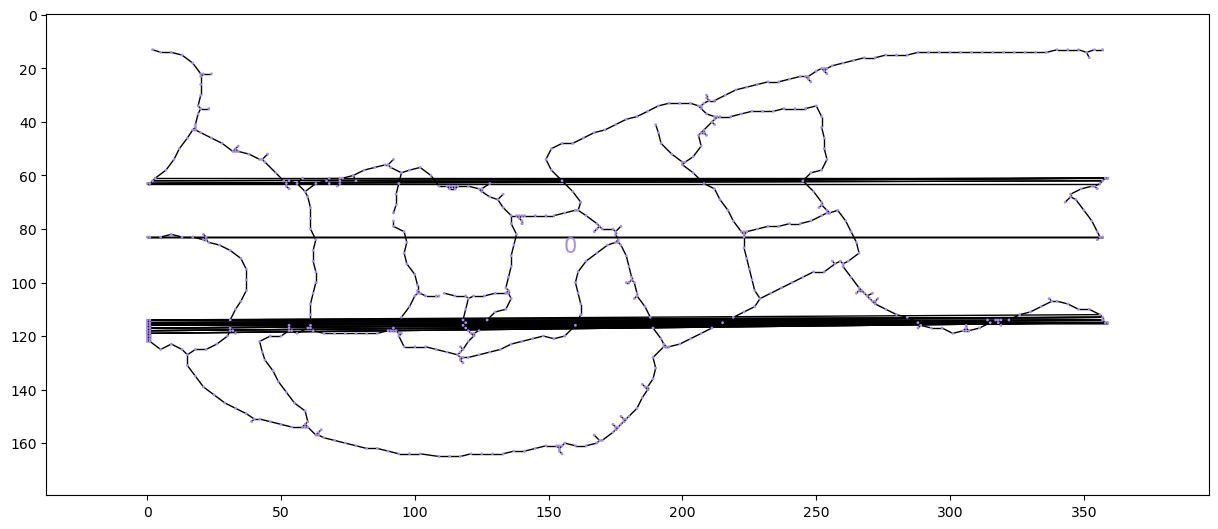

In [262]:
G = simplify(G, 2)

fig, ax = plt.subplots(1, 1, figsize=(15,15))
ax.imshow(np.zeros_like(cdata), 'gray_r', vmin=0)
plot_components(G, node_size=1, ax=ax)
# ax.set_xlim(0,200)
# ax.set_ylim(400,0)
plt.show()


## Structure of the network
Let's have a look at the structure of the fault network (or graph). Remember it only consists of nodes and edges. So let's have a look at the nodes:

In [220]:
print(G.nodes)

[3, 7, 11, 16, 20, 24, 28, 32, 36, 40, 42, 46, 51, 55, 56, 59, 63, 67, 71, 75, 77, 81, 82, 83, 84, 88, 93, 94, 99, 100, 102, 103, 105, 111, 112, 113, 117, 118, 120, 121, 124, 128, 129, 130, 131, 132, 135, 137, 138, 139, 140, 143, 145, 146, 147, 149, 152, 153, 157, 158, 161, 167, 170, 172, 176, 178, 186, 187, 192, 196, 197, 199, 200, 203, 206, 210, 211, 218, 222, 223, 228, 232, 233, 237, 238, 240, 242, 243, 248, 251, 256, 258, 259, 262, 266, 267, 269, 273, 277, 280, 283, 293, 297, 301, 303, 308, 309, 310, 315, 318, 322, 325, 327, 329, 330, 333, 335, 337, 343, 344, 350, 355, 357, 358, 360, 361, 362, 365, 369, 371, 372, 373, 378, 381, 382, 384, 387, 390, 394, 397, 401, 405, 409, 413, 414, 415, 416, 420, 424, 428, 429, 430, 431, 432, 433, 437, 440, 441, 442, 443, 444, 446, 452, 453, 454, 458, 459, 460, 461, 462, 463, 464, 465, 468, 469, 471, 472, 476, 477, 478, 480, 481, 483, 484, 486, 489, 492, 496, 499, 500, 501, 505, 510, 513, 514, 516, 517, 518, 519, 520, 521, 524, 525, 532, 533, 534, 

Okay, nothing special here, just a list of the nodes. Let's pick out one:

In [221]:
print(G.nodes[42])



{'pos': (np.int64(155), np.int64(164)), 'component': 0}


Alright, we can see the position of the node and the component it belongs to. Let's say we want to give it an extra property, e.g. the strain rate at its location:

In [263]:
# G.nodes[0]['strain_rate'] = cdata[int(G.nodes[0]['pos'][0]), int(G.nodes[0]['pos'][1])]

# Verify node 0 exists
if 0 in G.nodes:
    print(G.nodes[0])
else:
    print("Node 0 does not exist in the graph")

# Find a valid node to set the strain rate
valid_node = list(G.nodes)[0]  # Get the first valid node in the graph

# Print the node details
print(f"Using node {valid_node} to set the strain rate:")
print(G.nodes[valid_node])

# Set the strain rate for the valid node
G.nodes[valid_node]['strain_rate'] = cdata[int(G.nodes[valid_node]['pos'][0]), int(G.nodes[valid_node]['pos'][1])]

# Verify the strain rate is set
print(f"Strain rate for node {valid_node}: {G.nodes[valid_node]['strain_rate']}")

Node 0 does not exist in the graph
Using node 3 to set the strain rate:
{'pos': (np.int64(109), np.int64(165)), 'component': 0}
Strain rate for node 3: -16.75541814027211


In [264]:
# print(G.nodes[0])

for node in G.nodes:
    pos = G.nodes[node]['pos']
    G.nodes[node]['strain_rate'] = cdata[int(pos[1]), int(pos[0])]  # Notice the order is (y, x) for image indexing

# Verify the strain rates for a few nodes
for node in list(G.nodes)[:5]:  # Print the strain rates for the first 5 nodes
    print(f"Node {node}, Strain Rate: {G.nodes[node]['strain_rate']}")


Node 3, Strain Rate: -14.931945337557593
Node 7, Strain Rate: -14.815595626831055
Node 11, Strain Rate: -14.80673838260888
Node 16, Strain Rate: -16.316849841597495
Node 20, Strain Rate: -14.940212061113506


Nice! Let's do that for all nodes:

In [265]:
for node in G.nodes:
  G.nodes[node]['strain_rate'] = cdata[int(G.nodes[node]['pos'][1]), int(G.nodes[node]['pos'][0])]

and plot it:

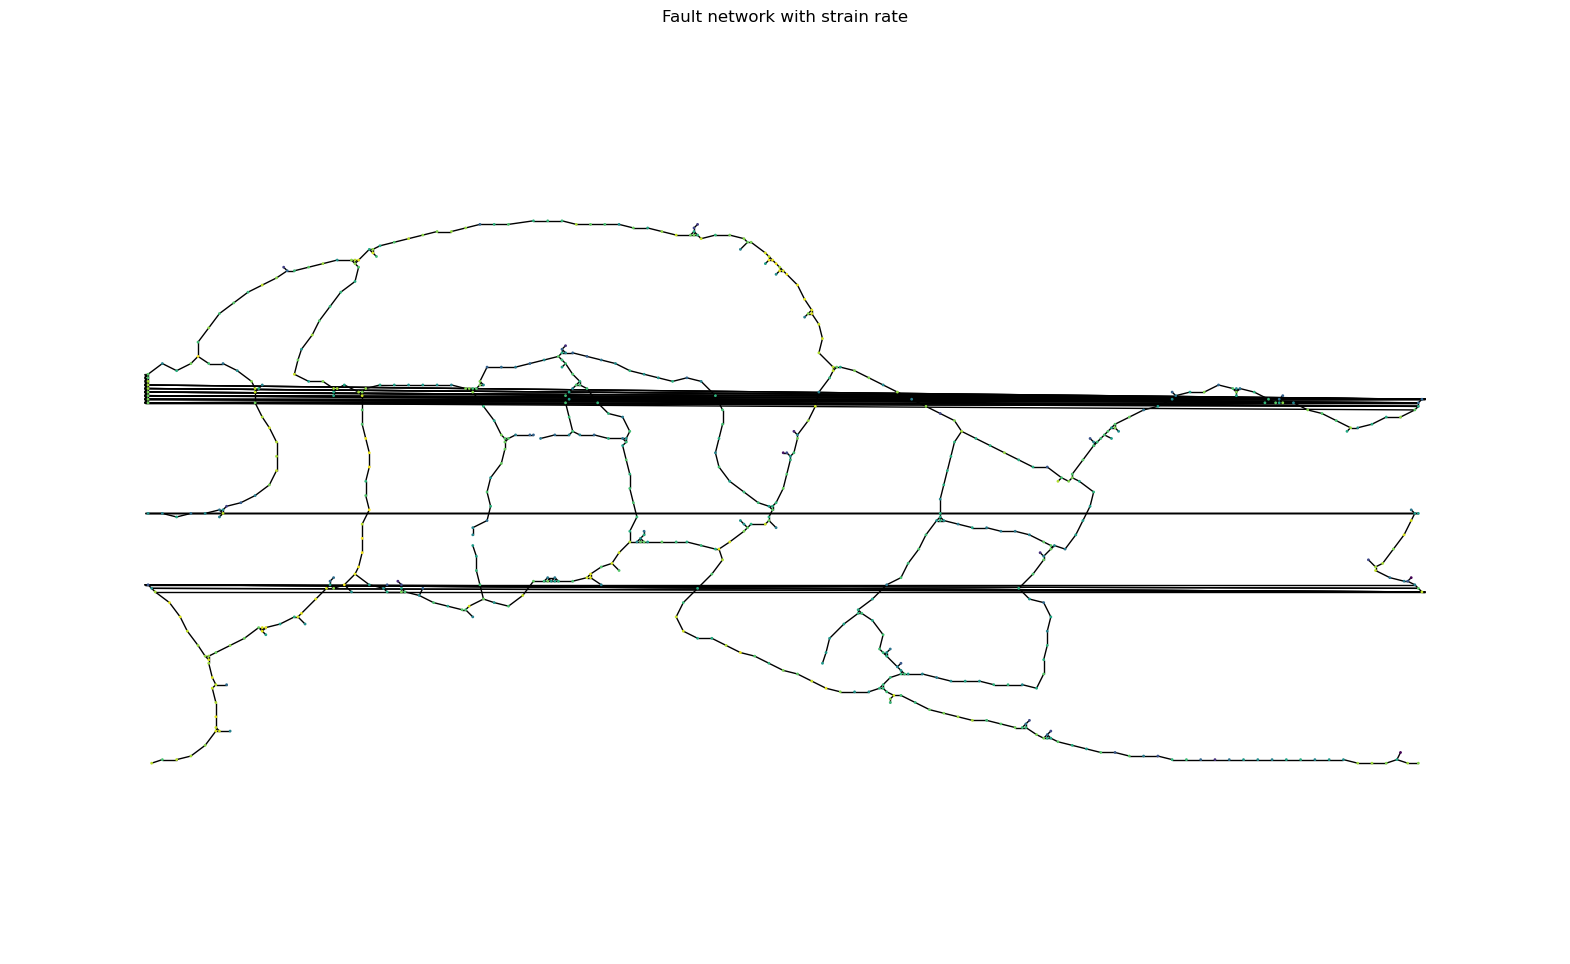

In [266]:
fig, ax = plt.subplots(figsize=(20,12))

ax.set_title('Fault network with strain rate')
nx.draw(G, 
        pos=nx.get_node_attributes(G, 'pos'),
        node_color = np.array([G.nodes[node]['strain_rate'] for node in G.nodes]), 
        node_size=1,
        ax=ax)
ax.axis('equal')
plt.show()

Like this we can compute and visualize all kinds of properties on the fault network.

But what about the edges?

In [267]:
print(G.edges)

[(3, 7), (3, 24), (7, 11), (11, 28), (16, 46), (16, 20), (20, 24), (28, 32), (32, 36), (36, 40), (40, 51), (42, 56), (46, 63), (51, 55), (55, 67), (56, 71), (59, 75), (59, 63), (67, 77), (71, 81), (71, 82), (71, 83), (75, 93), (77, 81), (81, 82), (82, 83), (83, 94), (84, 94), (84, 88), (88, 99), (93, 100), (99, 102), (100, 105), (102, 103), (102, 113), (103, 118), (105, 112), (111, 112), (111, 117), (111, 130), (112, 117), (117, 120), (118, 121), (121, 131), (121, 132), (124, 135), (124, 128), (128, 129), (128, 137), (129, 130), (129, 137), (130, 137), (131, 132), (131, 138), (132, 139), (135, 143), (137, 145), (139, 146), (140, 147), (143, 149), (145, 167), (146, 152), (146, 153), (147, 149), (147, 161), (152, 153), (152, 157), (153, 158), (158, 172), (161, 170), (167, 178), (170, 176), (172, 186), (176, 187), (178, 192), (186, 196), (187, 197), (192, 206), (196, 199), (196, 200), (197, 211), (199, 200), (199, 203), (200, 210), (206, 218), (210, 222), (211, 223), (218, 232), (222, 242

Alright, just tuples of nodes. Let's pick one:

In [271]:
# print(G.edges[(3, 4)])
# Print details for the first few edges
for i, edge in enumerate(list(G.edges)[:5]):  # Print details for the first 5 edges
    print(f"Edge {i}: {edge}")

# Check the existence of a specific edge
def check_edge_existence(G, u, v):
    if u in G.nodes and v in G.nodes:
        if (u, v) in G.edges:
            return G.edges[(u, v)]
        else:
            return f"Edge ({u}, {v}) does not exist."
    else:
        return f"One or both of the nodes {u} and {v} do not exist."



Edge 0: (3, 7)
Edge 1: (3, 24)
Edge 2: (7, 11)
Edge 3: (11, 28)
Edge 4: (16, 46)


Okay, they have no property yet. Let's calculate its length:

In [272]:
# G.edges[edge]['length'] = np.linalg.norm(np.array(G.nodes[edge[0]]['pos'])-np.array(G.nodes[edge[1]]['pos']))


def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points on the Earth using the Haversine formula.
    """
    # Earth radius in kilometers
    R = 6371.0

    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c

    return distance

# Initialize variable to track the maximum length
max_length = 0
max_length_edge = None


for edge in G.edges:
    if edge[0] in G.nodes and edge[1] in G.nodes:
        pos1 = G.nodes[edge[0]]['pos']
        pos2 = G.nodes[edge[1]]['pos']

        lon1, lat1 = pos1
        lon2, lat2 = pos2

        # Adjust for wrap-around if the difference in longitude exceeds 180 degrees
        if abs(lon2 - lon1) > 180:
            if lon1 < 0:
                lon1 += 360
            else:
                lon2 += 360

        # Calculate the distance using the Haversine formula
        length = haversine_distance(lat1, lon1, lat2, lon2)
        G.edges[edge]['length'] = length
        
        # Update max_length if the current length is greater
        if length > max_length:
            max_length = length
            max_length_edge = edge
    else:
        print(f"One or both of the nodes {edge} do not exist in the graph.")
    
# Print edge lengths
for edge in G.edges:
    print(f"Edge {edge}, Length: {G.edges[edge]['length']}")

# Print the maximum length and the corresponding edge
print(f"Maximum edge length is {max_length} for edge {max_length_edge}")

Edge (3, 7), Length: 429.6183584942848
Edge (3, 24), Length: 758.2085957216292
Edge (7, 11), Length: 429.6183584942835
Edge (11, 28), Length: 442.7798599462155
Edge (16, 46), Length: 440.7081644110618
Edge (16, 20), Length: 427.54309543041524
Edge (20, 24), Length: 427.54309543041654
Edge (28, 32), Length: 427.54309543041654
Edge (32, 36), Length: 427.5430954304138
Edge (36, 40), Length: 427.54309543041654
Edge (40, 51), Length: 440.7081644110618
Edge (42, 56), Length: 154.0482779740605
Edge (46, 63), Length: 438.5114286104119
Edge (51, 55), Length: 425.3375617788759
Edge (55, 67), Length: 438.5114286104132
Edge (56, 71), Length: 111.19492664456031
Edge (59, 75), Length: 436.1904634567665
Edge (59, 63), Length: 423.0024315588709
Edge (67, 77), Length: 436.19046345676384
Edge (71, 81), Length: 153.24278537475726
Edge (71, 82), Length: 111.19492664455747
Edge (71, 83), Length: 153.24278537475544
Edge (75, 93), Length: 433.74612875627764
Edge (77, 81), Length: 420.5384183608992
Edge (81, 

In [273]:
# Let's print the edge with the maximum distance 
print(G.edges[max_length_edge])

{'length': np.float64(758.2085957216292)}


Again, we can do this for all edges:

In [274]:
# for edge in G.edges:
#   G.edges[edge]['length'] = np.linalg.norm(np.array(G.nodes[edge[0]]['pos'])-np.array(G.nodes[edge[1]]['pos']))

and plot it:

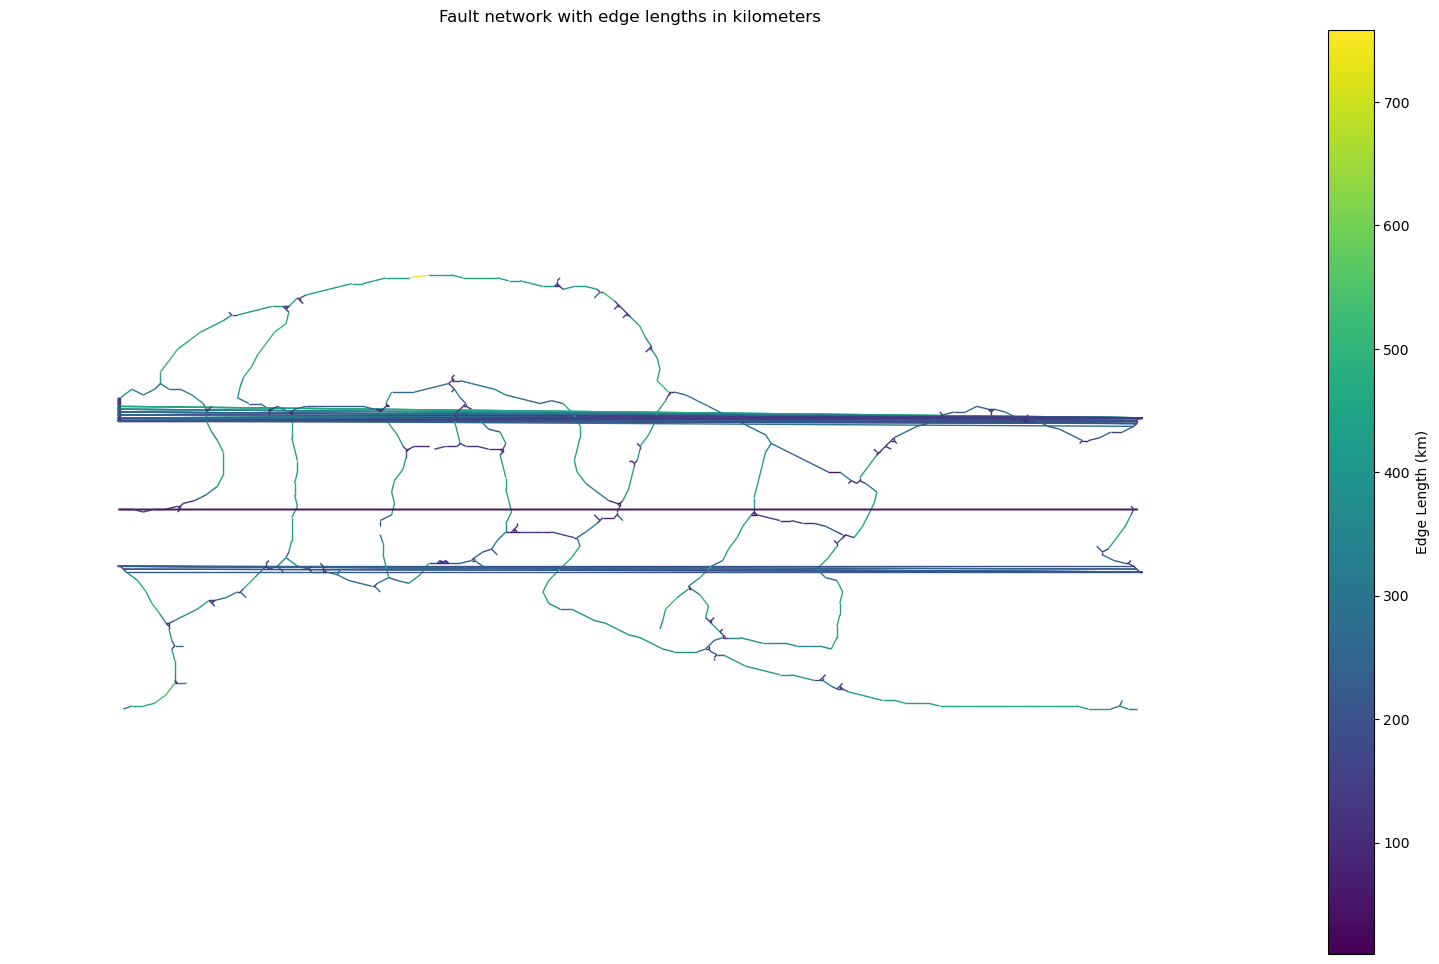

Maximum edge length is 758.2085957216292 km for edge (3, 24)


In [275]:
# fig, ax = plt.subplots(figsize=(20,12))

# ax.set_title('Fault network with edge lenghts')
# nx.draw(G, 
#         pos=nx.get_node_attributes(G, 'pos'),
#         edge_color = np.array([G.edges[edge]['length'] for edge in G.edges]), 
#         node_size=0.001,
#         ax=ax)
# ax.axis('equal')
# plt.show()

import matplotlib.cm as cm
import matplotlib.colors as mcolors
# Extract edge lengths
edge_lengths = np.array([G.edges[edge]['length'] for edge in G.edges])

# Normalize edge lengths for colormap
norm = mcolors.Normalize(vmin=edge_lengths.min(), vmax=edge_lengths.max())
cmap = cm.viridis

# Generate colors based on lengths
edge_colors = [cmap(norm(length)) for length in edge_lengths]

# Draw the graph
fig, ax = plt.subplots(figsize=(20, 12))

ax.set_title('Fault network with edge lengths in kilometers')
nx.draw(G, 
        pos=nx.get_node_attributes(G, 'pos'),
        edge_color=edge_colors, 
        node_size=0.001,
        ax=ax,
        with_labels=False,
        edge_cmap=cmap,
        edge_vmin=edge_lengths.min(),
        edge_vmax=edge_lengths.max())
ax.axis('equal')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Edge Length (km)')

plt.show()

# Print the maximum length and the corresponding edge
print(f"Maximum edge length is {max_length} km for edge {max_length_edge}")

In [279]:
import numpy as np
import networkx as nx
import pyvista as pv
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def latlon_to_cartesian(lat, lon, radius=6371.0):
    """
    Convert latitude and longitude to Cartesian coordinates.
    """
    lat, lon = np.radians(lat), np.radians(lon)
    x = radius * np.cos(lat) * np.cos(lon)
    y = radius * np.cos(lat) * np.sin(lon)
    z = radius * np.sin(lat)
    return x, y, z

def great_circle_interpolation(lat1, lon1, lat2, lon2, n_points=100, radius=6371.0):
    lat1, lon1 = np.radians(lat1), np.radians(lon1)
    lat2, lon2 = np.radians(lat2), np.radians(lon2)

    delta_lat = lat2 - lat1
    delta_lon = lon2 - lon1

    a = np.sin(delta_lat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(delta_lon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = radius * c

    t = np.linspace(0, 1, n_points)
    lat_interp = lat1 + t * delta_lat
    lon_interp = lon1 + t * delta_lon

    x_interp = radius * np.cos(lat_interp) * np.cos(lon_interp)
    y_interp = radius * np.cos(lat_interp) * np.sin(lon_interp)
    z_interp = radius * np.sin(lat_interp)

    return x_interp, y_interp, z_interp

# Initialize variable to track the maximum length
max_length = 0
max_length_edge = None

# Calculate and set the length of each edge
for edge in G.edges:
    if edge[0] in G.nodes and edge[1] in G.nodes:
        pos1 = G.nodes[edge[0]]['pos']
        pos2 = G.nodes[edge[1]]['pos']

        lon1, lat1 = pos1
        lon2, lat2 = pos2

        if abs(lon2 - lon1) > 180:
            if lon1 < 0:
                lon1 += 360
            else:
                lon2 += 360

        length = haversine_distance(lat1, lon1, lat2, lon2)
        G.edges[edge]['length'] = length

        if length > max_length:
            max_length = length
            max_length_edge = edge
    else:
        print(f"One or both of the nodes {edge} do not exist in the graph.")

# Extract edge lengths
edge_lengths = np.array([G.edges[edge]['length'] for edge in G.edges])

# Normalize edge lengths for colormap
norm = mcolors.Normalize(vmin=edge_lengths.min(), vmax=edge_lengths.max())
cmap = cm.viridis

# Generate colors based on lengths
edge_colors = [cmap(norm(length)) for length in edge_lengths]

# Convert positions to Cartesian coordinates
cartesian_positions = {}
for node in G.nodes:
    lon, lat = G.nodes[node]['pos']
    x, y, z = latlon_to_cartesian(lat, lon)
    cartesian_positions[node] = (x, y, z)

# Create a PyVista plotter
plotter = pv.Plotter()

# Add a sphere to represent the Earth
sphere = pv.Sphere(radius=6371.0, theta_resolution=360, phi_resolution=180)
plotter.add_mesh(sphere, color='white', opacity=0.6, style='wireframe')

# Add nodes to the plotter
points = np.array(list(cartesian_positions.values()))
point_cloud = pv.PolyData(points)
plotter.add_mesh(point_cloud, color='red', point_size=10, render_points_as_spheres=True)

# Add edges to the plotter using great-circle interpolation
for i, edge in enumerate(G.edges):
    pos1 = G.nodes[edge[0]]['pos']
    pos2 = G.nodes[edge[1]]['pos']
    lon1, lat1 = pos1
    lon2, lat2 = pos2

    x_interp, y_interp, z_interp = great_circle_interpolation(lat1, lon1, lat2, lon2)
    edge_line = pv.PolyData(np.column_stack((x_interp, y_interp, z_interp)))
    plotter.add_mesh(edge_line, color=edge_colors[i])

# Show the plot
plotter.show()

# Print the maximum length and the corresponding edge
print(f"Maximum edge length is {max_length} km for edge {max_length_edge}")


Widget(value='<iframe src="http://localhost:65455/index.html?ui=P_0x36e675900_18&reconnect=auto" class="pyvist…

Maximum edge length is 758.2085957216292 km for edge (3, 24)


Awesome! That's it. You've extracted your first fault network. In the next tutorial, we will learn how to compute and visualize fault strikes:
https://github.com/thilowrona/fault_analysis_toolbox/blob/master/examples/2-fault_properties/2-fault_properties.ipynb 

In [75]:
import pickle
with open('/Users/ponsm/Desktop/software/fatbox/fatbox_Pons/plate_bourndaries.p','wb') as p:
    pickle.dump(G,p)

Graph with 890 nodes and 439 edges


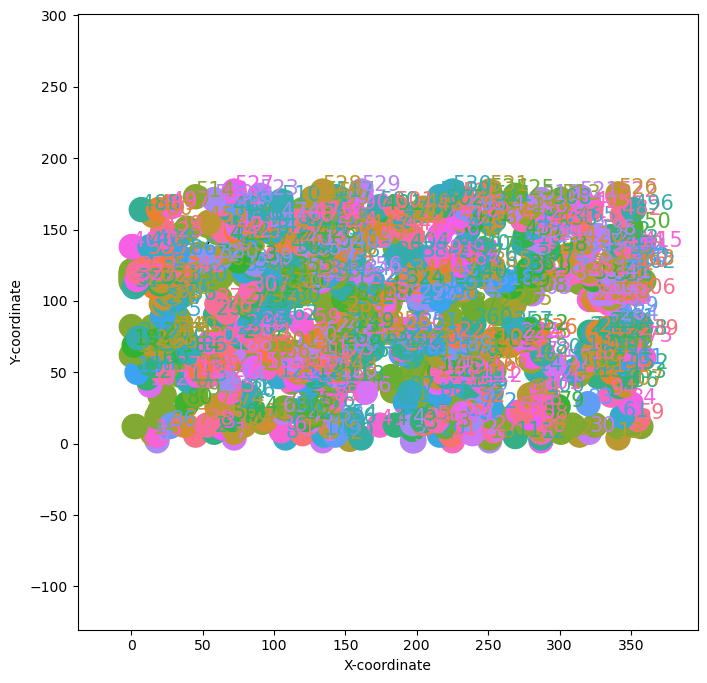

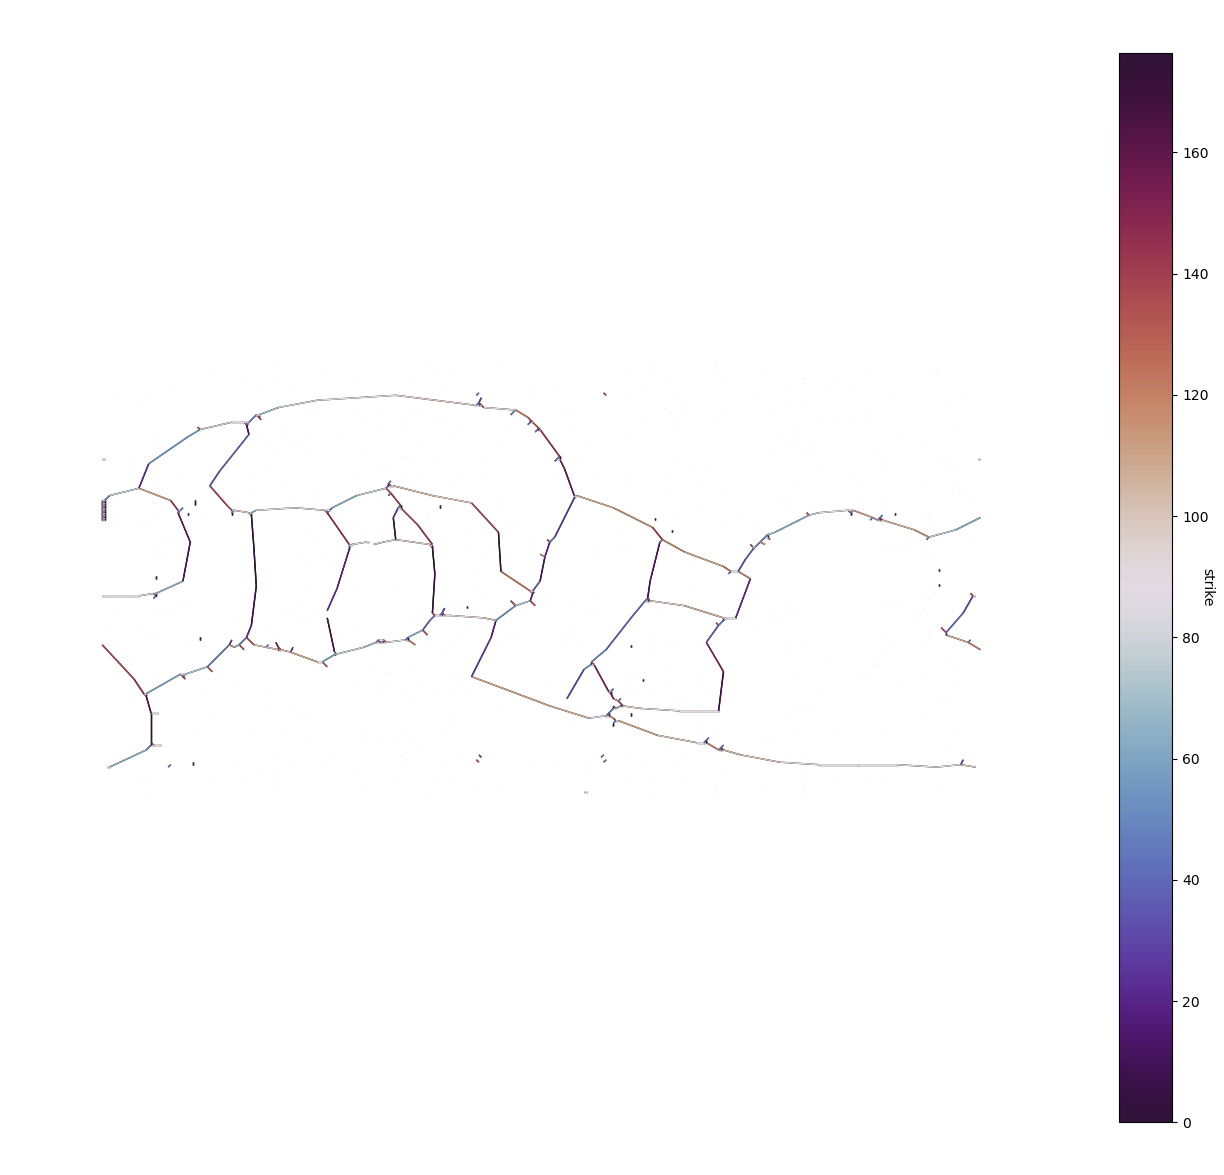

/Users/ponsm/anaconda3/envs/extra_postprocess/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ponsm/anaconda3/envs/extra_postprocess/lib/python3.10/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


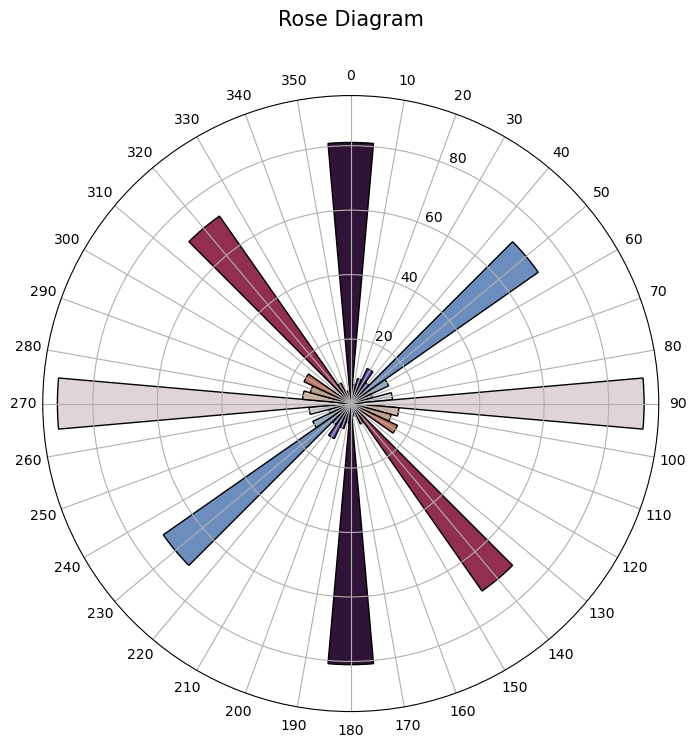

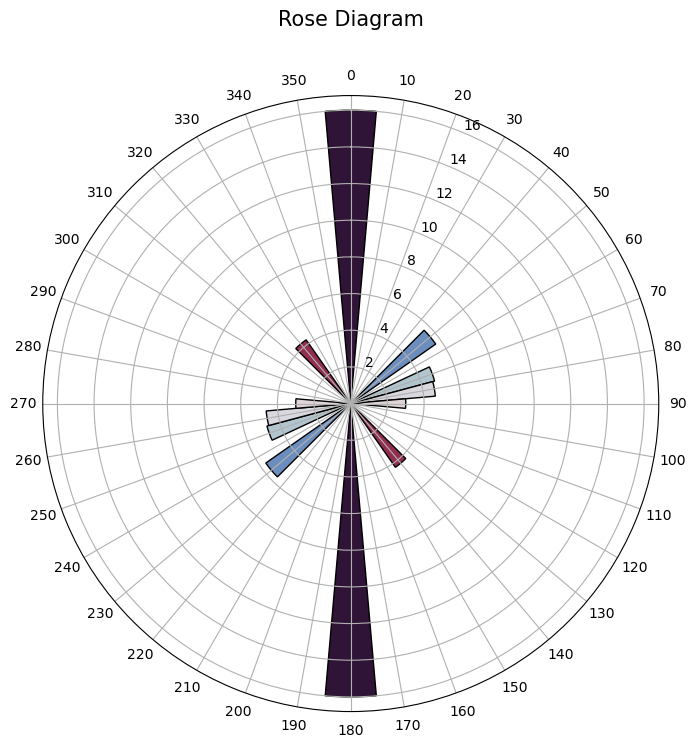

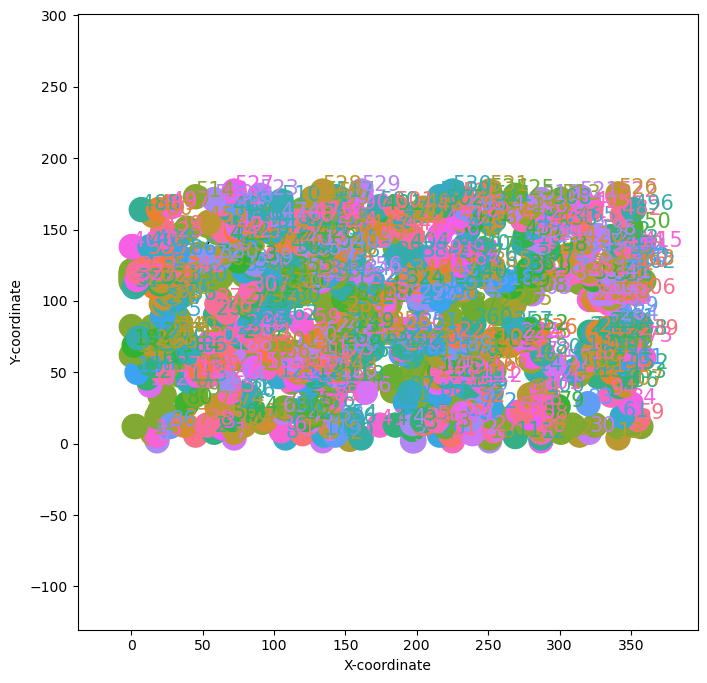

In [76]:
import math
import numpy as np
import networkx as nx
import pickle
import matplotlib.pyplot as plt

from fatbox.metrics import compute_edge_values
from fatbox.plots import plot_components, plot_edge_attribute, plot_rose

# %% [markdown]
# ## Load fault network
G = pickle.load(open('/Users/ponsm/Desktop/software/fatbox/fatbox_Pons/plate_bourndaries.p', 'rb'))

# %% [markdown]
# Now we can visualize the faults and look at the orientations:
print(G)

# %%
fig, ax = plt.subplots(figsize=(8, 8))
plot_components(G, ax=ax, label=True)
ax.axis('equal')
ax.set_xlabel('X-coordinate')
ax.set_ylabel('Y-coordinate')
plt.show()

# %%
# for edge in G.edges:
#     x1 = G.nodes[edge[0]]['pos'][0]
#     x2 = G.nodes[edge[1]]['pos'][0]
#     y1 = G.nodes[edge[0]]['pos'][1]
#     y2 = G.nodes[edge[1]]['pos'][1]

#     if (x2 - x1) < 0:
#         strike = math.degrees(math.atan2((x2 - x1), (y2 - y1))) + 360
#     else:
#         strike = math.degrees(math.atan2((x2 - x1), (y2 - y1)))

#     # Scale to [0, 180]
#     if strike <= 180:
#         G.edges[edge]['strike'] = strike
#     else:
#         G.edges[edge]['strike'] = strike - 180

for edge in G.edges:
    x1 = G.nodes[edge[0]]['pos'][0]
    x2 = G.nodes[edge[1]]['pos'][0]
    y1 = G.nodes[edge[0]]['pos'][1]
    y2 = G.nodes[edge[1]]['pos'][1]

    # Calculate the angle in radians, then convert to degrees
    angle_rad = math.atan2((x2 - x1), (y2 - y1))
    angle_deg = math.degrees(angle_rad)

    # Normalize the strike to be within [0, 360) degrees
    strike = angle_deg if angle_deg >= 0 else angle_deg + 360

    # Further normalize the strike to [0, 180) for bidirectional faults
    if strike >= 180:
        strike -= 180

    G.edges[edge]['strike'] = strike


# %% [markdown]
# Let's plot these strikes as edge attributes using this function:

# %%
def plot_edge_attribute(G, attribute, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    pos = nx.get_node_attributes(G, 'pos')
    edges = np.array([G.edges[edge][attribute] for edge in G.edges])

    nx.draw(G, pos=pos, node_size=0.001, ax=ax)
    nx.draw_networkx_edges(G, pos=pos, edge_color=edges, edge_cmap=plt.cm.twilight_shifted, ax=ax)
    ax.axis('equal')

    # Colorbar
    cmap = plt.cm.twilight_shifted
    vmax = compute_edge_values(G, attribute, 'max')
    vmin = compute_edge_values(G, attribute, 'min')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])

    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel(attribute, rotation=270)

# %%
fig, ax = plt.subplots(figsize=(15, 15))
plot_edge_attribute(G, 'strike', ax=ax)
plt.show()

# %% [markdown]
# Looks a bit odd, let's zoom in:

# # %%
# fig, ax = plt.subplots(figsize=(15, 15))
# plot_edge_attribute(G, 'strike', ax=ax)
# ax.set_ylim([50, 150])
# plt.show()


# %% [markdown]
# Okay, the edges have very discrete strikes (0, 45, 90 degrees), because they were extracted from a regular array. This becomes even more evident when we plot the Rose diagram (a polar histogram of the strikes):

# %%
def plot_rose(strikes, lengths=[], ax=[]):    
    
    if lengths ==[]:
        lengths = np.ones_like(np.array(strikes))

    bin_edges = np.arange(-5, 366, 10)
    number_of_strikes, bin_edges = np.histogram(strikes, bin_edges, weights = lengths)           
    number_of_strikes[0] += number_of_strikes[-1]
    half = np.sum(np.split(number_of_strikes[:-1], 2), 0)
    two_halves = np.concatenate([half, half])
    
    cmap = plt.cm.twilight_shifted(np.concatenate((np.linspace(0, 1, 18), np.linspace(0, 1, 18)), axis=0))
     
    if ax==[]:
        fig = plt.figure(figsize=(8,8))
            
        ax = fig.add_subplot(111, projection='polar')
    
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.arange(0, 360, 10), labels=np.arange(0, 360, 10))
    
    ax.bar(np.deg2rad(np.arange(0, 360, 10)), two_halves, 
           width=np.deg2rad(10), bottom=0.0, color=cmap, edgecolor='k')
    
    #    ax.set_rgrids(np.arange(1, two_halves.max() + 1, 2), angle=0, weight= 'black')
    ax.set_title('Rose Diagram', y=1.10, fontsize=15)
    
    # fig.tight_layout()


# %%
strikes = [G.edges[edge]['strike'] for edge in G.edges]
plot_rose(strikes)

# %% [markdown]
# Okay, that's not really what we want. We want the strikes of the faults, not the edges. So let's calculate those:

# %%
strikes = []
for cc in nx.connected_components(G):
  edges = G.edges(cc)
  edge_strikes = []
  for edge in edges:
    edge_strikes.append(G.edges[edge]['strike'])
  strikes.append(np.mean(edge_strikes))

# %% [markdown]
# and the fault lenghts as weights:

# %%
for edge in G.edges:
  G.edges[edge]['length'] = np.linalg.norm(np.array(G.nodes[edge[0]]['pos'])-np.array(G.nodes[edge[1]]['pos']))

# %%
lengths = []
for cc in nx.connected_components(G):
  edges = G.edges(cc)
  edge_lengths = []
  for edge in edges:
    edge_lengths.append(G.edges[edge]['length'])
  lengths.append(np.mean(edge_lengths))

# %% [markdown]
# Now we can plot the Rose diagram again:

# %%
plot_rose(strikes, lengths)

# %% [markdown]
# That's a much better representation of the fault strikes in our network!

# %%
fig, ax = plt.subplots(figsize=(8,8))
plot_components(G, ax=ax, label=True)
ax.axis('equal')
ax.set_xlabel('X-coordinate')
ax.set_ylabel('Y-coordinate')
plt.show()

# %%





In [110]:
import math
import pickle

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import networkx as nx
import numpy as np
from ipywidgets import Layout, interactive, widgets
from tqdm import tqdm

from fatbox.metrics import total_length, get_fault, get_fault_labels
from fatbox.plots import plot_components, plot_attribute, plot_faults

# Ensure inline plotting
%matplotlib inline

# List to store the loaded graphs
Gs = []

# Loop to load the graphs
for n in range(1, 3):  # Corrected the range to include one file
    Gs.append(pickle.load(open('/Users/ponsm/Desktop/software/fatbox/fatbox_Pons/plate_bourndaries_' + str(n) + '.p', 'rb')))
    print(n)
# Define the plotting function
def f(time):
    fig, ax = plt.subplots(figsize=(16, 4))
    plot_components(Gs[time-1], node_size=1, ax=ax)  # Adjusted index to match slider range
    # plt.xlim([1000, 3500])
    # plt.ylim([600, 0])
    plt.show()
# print(len(Gs))
# Create interactive plot with a correct slider range
interactive_plot = interactive(f, time=widgets.IntSlider(min=1, max=len(Gs), step=1, layout=Layout(width='900px')))
output = interactive_plot.children[-1]
output.layout.width = '1000px'
interactive_plot


1
2


interactive(children=(IntSlider(value=1, description='time', layout=Layout(width='900px'), max=2, min=1), Outp…

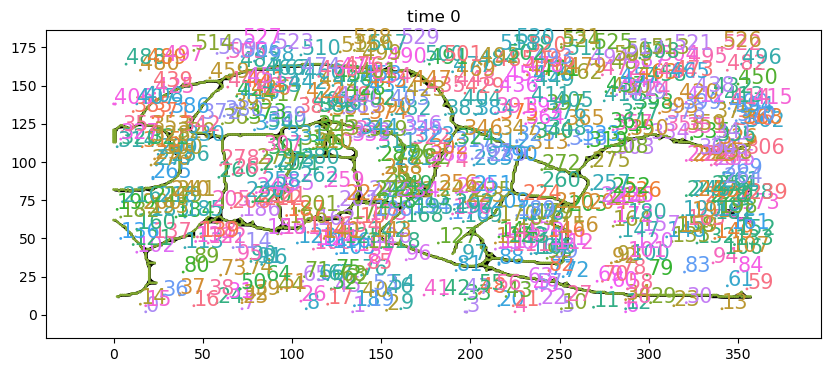

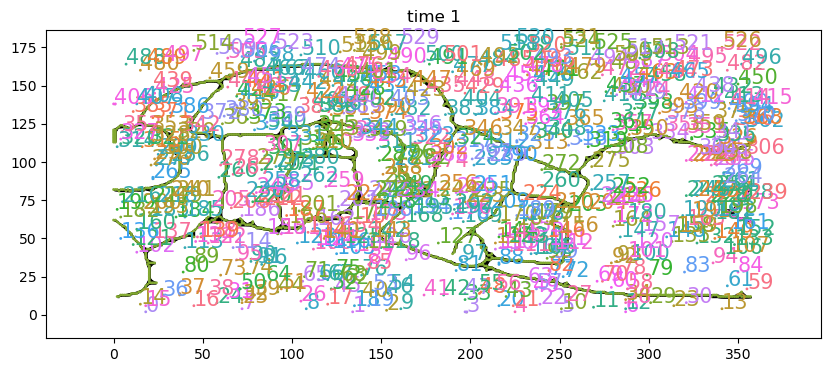

In [111]:
G_0 = Gs[0]
G_1 = Gs[1]

fig, ax = plt.subplots(figsize=(10,4))
plot_components(G_0, node_size=1, ax=ax)
ax.set_title('time 0')
# ax.set_xlim([1750, 2750])
# ax.set_ylim([500, 0])
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
plot_components(G_1, node_size=1, ax=ax)
ax.set_title('time 1')
# ax.set_xlim([1750, 2750])
# ax.set_ylim([500, 0])
plt.show()

In [112]:
for node in G_0:
    G_0.nodes[node]['fault'] = G_0.nodes[node]['component']

for node in G_1:
    G_1.nodes[node]['fault'] = G_1.nodes[node]['component']

print(G_0.nodes[0])

{'pos': (np.int64(18), np.int64(2)), 'component': 0, 'strain_rate': np.float64(-14.639539288358042), 'fault': 0}


In [113]:
def get_nodes(G):
    labels = get_fault_labels(G)
    point_set=[]
    for label in labels:            
        G_fault = get_fault(G, label)
        points = []
        for node in G_fault:
            points.append(G_fault.nodes[node]['pos'])
        point_set.append(points)
    return point_set


def compute_similarity(set_A, set_B):
      distances = np.zeros((len(set_A), len(set_B)))
      for n, pt_0 in enumerate(set_A):
          for m, pt_1 in enumerate(set_B):
              distances[n,m] = math.sqrt((pt_0[0]-pt_1[0])**2 + (pt_0[1]-pt_1[1])**2)
      return np.mean(np.min(distances, axis=1))

 
def correlation_slow(G_0, G_1, R):
    # A function which labels the faults in G_1 according to G_0 using the 
    # minimum radius R
    
    
    # Get labels and nodes
    fault_labels_0 = get_fault_labels(G_0)
    fault_labels_1 = get_fault_labels(G_1)
    
    nodes_0 = get_nodes(G_0)
    nodes_1 = get_nodes(G_1) 


    # Compute similarities    
    smf = np.zeros((len(fault_labels_0), len(fault_labels_1)))
    smb = np.zeros((len(fault_labels_1), len(fault_labels_0)))    
    
    
    for n in tqdm(range(len(fault_labels_0)), desc='   Compute similarities'):
        for m in range(len(fault_labels_1)):
            smf[n,m] = compute_similarity(nodes_0[n], nodes_1[m])
            smb[m,n] = compute_similarity(nodes_1[m], nodes_0[n])
            
            
    # Determine correlations
    correlations = set()
    for n in tqdm(range(len(fault_labels_0)), desc='   Find correlations'):
        for m in range(len(fault_labels_1)):
            if smf[n,m] < R:
                correlations.add((fault_labels_0[n], fault_labels_1[m]))
            if smb[m,n] < R:
                correlations.add((fault_labels_0[n], fault_labels_1[m]))                 

    return correlations, smf, smb

In [114]:
R = 5
correlations, smf, smb = correlation_slow(G_0, G_1, R=R)

   Find correlations: 100%|██████████| 532/532 [00:00<00:00, 9436.64it/s]


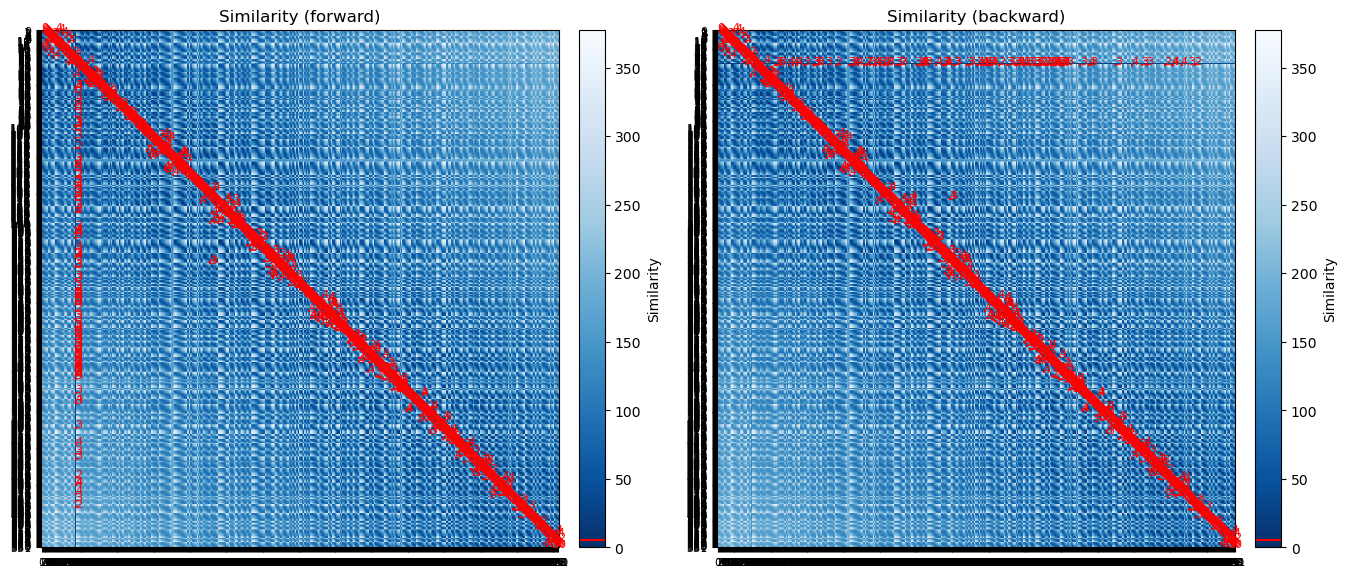

In [115]:
fig, axs = plt.subplots(1, 2, figsize=(16,8))

axs[0].set_title('Similarity (forward)')
im_0 = axs[0].imshow(smf, cmap='Blues_r')
axs[0].set_yticks(range(smf.shape[0]))
axs[0].set_yticklabels(get_fault_labels(G_0), fontsize=8)
axs[0].set_xticks(range(smf.shape[1]))
axs[0].set_xticklabels(get_fault_labels(G_1), fontsize=8)

divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.2)
cbar = fig.colorbar(im_0, cax=cax, orientation='vertical')
cbar.set_label('Similarity')

cbar.ax.plot([0, 800], [R]*2, 'r')

for x in range(smf.shape[0]):
    for y in range(smf.shape[1]):
        if smf[x,y] < R:
            axs[0].text(y-0.25,x+0.25, int(smf[x,y]), color='red', fontsize=8)
            rect = patches.Rectangle((y-0.5, x-0.5), 1, 1, linewidth=1, edgecolor='r', facecolor='none')
            axs[0].add_patch(rect)
        else:
            pass


axs[1].set_title('Similarity (backward)')
im_1 = axs[1].imshow(np.transpose(smb), cmap='Blues_r')
axs[1].set_yticks(range(smf.shape[0]))
axs[1].set_yticklabels(get_fault_labels(G_0), fontsize=8)
axs[1].set_xticks(range(smf.shape[1]))
axs[1].set_xticklabels(get_fault_labels(G_1), fontsize=8)

divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.2)
cbar = fig.colorbar(im_1, cax=cax, orientation='vertical')
cbar.set_label('Similarity')

cbar.ax.plot([0, 800], [R]*2, 'r')

for x in range(smb.shape[0]):
    for y in range(smb.shape[1]):
        if smb[x,y] < R:
            axs[1].text(x-0.25,y+0.25, int(smb[x,y]), color='red', fontsize=8)
            rect = patches.Rectangle((x-0.5, y-0.5), 1, 1, linewidth=1, edgecolor='r', facecolor='none')
            axs[1].add_patch(rect)
        else:
            pass

plt.show()

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

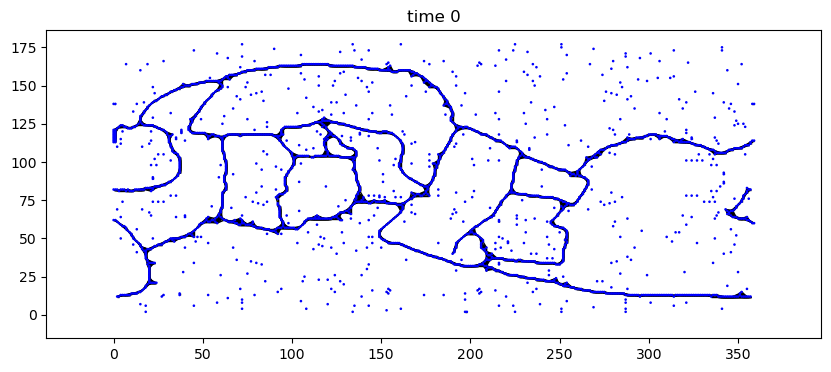

In [116]:
import matplotlib.colors
cmap_rb = matplotlib.colors.ListedColormap(['red', 'blue'])

for node in G_0:
    if G_0.nodes[node]['fault'] in [corr[0] for corr in correlations]:
        G_0.nodes[node]['correlated'] = 1
    else:
        G_0.nodes[node]['correlated'] = 0


for node in G_1:
    if G_1.nodes[node]['fault'] in [corr[1] for corr in correlations]:
        G_1.nodes[node]['correlated'] = 1
    else:
        G_1.nodes[node]['correlated'] = 0



fig, ax = plt.subplots(1,1,figsize=(10,4))
ax.set_title('time 0')
plot_attribute(G_0, 'correlated', cmap=cmap_rb, vmin=0, vmax=1, ax=ax)
ax.set_xlim([1750, 2750])
ax.set_ylim([500, 0])
plt.show()


fig, ax = plt.subplots(1,1,figsize=(10,4))
ax.set_title('time 1')
plot_attribute(G_1, 'correlated', cmap=cmap_rb, vmin=0, vmax=1, ax=ax)
# ax.set_xlim([1750, 2750])
# ax.set_ylim([500, 0])
plt.show()

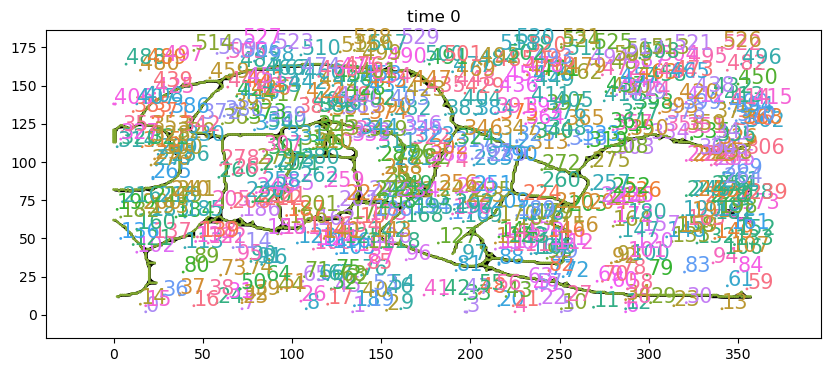

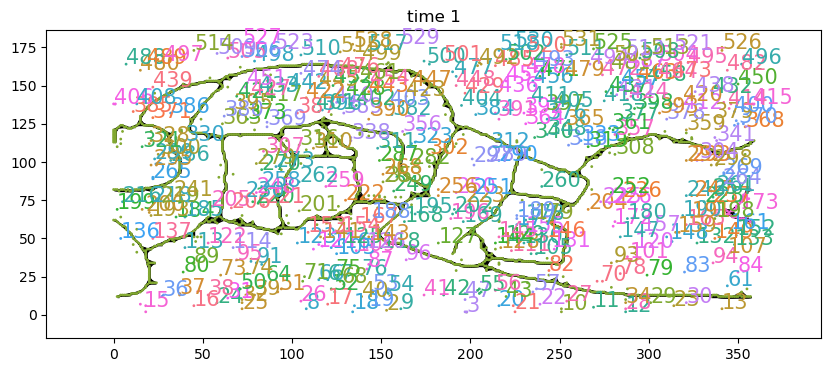

In [117]:
def relabel(G_1, correlations):
        
    # A function, which relabels G_1 using the correlations
    for node in G_1:
        G_1.nodes[node]['correlated']=0
    
    lengths = [total_length(get_fault(G_0, correlation[0]), calculate=True) for correlation in correlations]
    lengths, correlations = zip(*sorted(zip(lengths, correlations)))
    
    
    for node in G_1:
        for correlation in correlations:
            if G_1.nodes[node]['component'] == correlation[1]:
                G_1.nodes[node]['fault'] = correlation[0]
                G_1.nodes[node]['correlated'] = 1
    
    max_comp = max(get_fault_labels(G_1))
    
    G_1_sub = nx.subgraph(G_1, [node for node in G_1 if G_1.nodes[node]['correlated']==0])  
    for label, cc in enumerate(sorted(nx.connected_components(G_1_sub))): 
        for n in cc:
            G_1.nodes[n]['fault'] = label+max_comp+1
        
    return G_1


G_1 = relabel(G_1, correlations)

fig, ax = plt.subplots(figsize=(10,4))
plot_faults(G_0, node_size=1, ax=ax)
ax.set_title('time 0')
# ax.set_xlim([1750, 2750])
# ax.set_ylim([500, 0])
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
plot_faults(G_1, node_size=1, ax=ax)
ax.set_title('time 1')
# ax.set_xlim([1750, 2750])
# ax.set_ylim([500, 0])
plt.show()

TypeError: plot_faults() got multiple values for argument 'label'

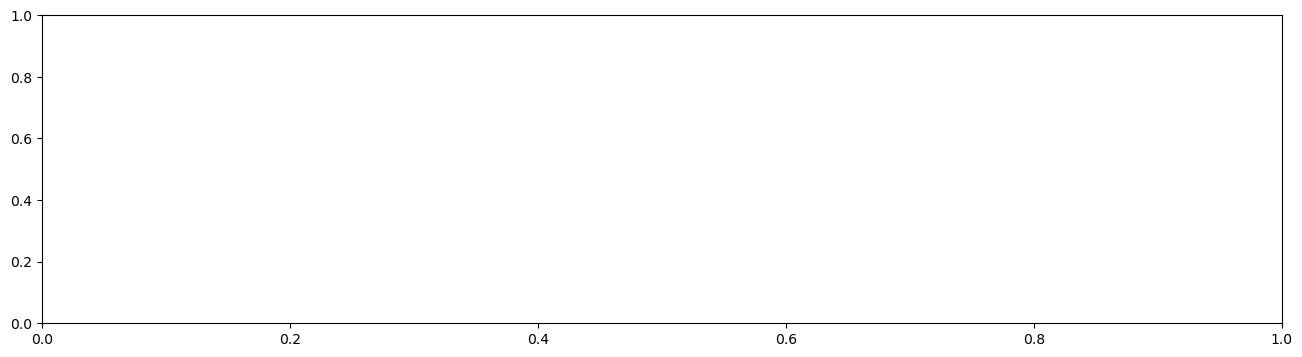

In [123]:
import math
import pickle

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from fatbox.metrics import total_length
from fatbox.plots import plot_faults, plot_components, plot_attribute

G = pickle.load(open('/Users/ponsm/Desktop/software/fatbox/fatbox_Pons/plate_bourndaries_1.p', 'rb'))

fig, ax = plt.subplots(figsize=(16,4))
plot_faults(G, ax, label=True)
# plt.xlim([1000, 3500])
# plt.ylim([600, 0])
plt.show()

KeyError: 'fault'

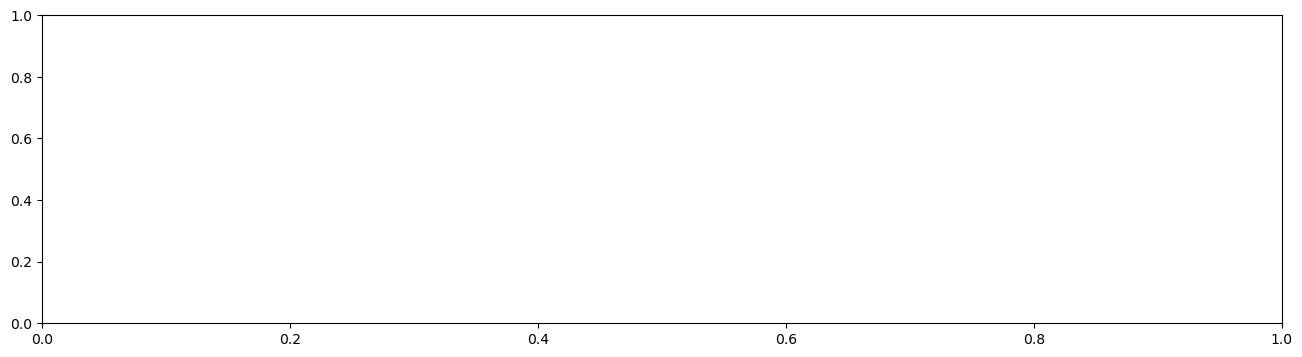